In [ ]:
"""
task1_analysis.py
Cyclone Machine Sensor Data Analysis (adapted for /mnt/data/data.xlsx)

- Robust to Excel parsing quirks (unknown extensions warning)
- Ensures numeric dtypes before interpolation (fixes the TypeError you saw)
- Produces outputs in outputs/ and plots/ folders

Author: ChatGPT (adapted for your dataset)
Date: Oct 2025
"""
import os
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML & TS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score

# Statsmodels (ARIMA fallback)
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# OUTPUT DIRS
os.makedirs("plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


# ---------------------------
# CONFIG
# ---------------------------
DATA_FILE = "data.xlsx"   # <-- update if your file path differs
FREQ = "5T"                         # strict 5-minute frequency
MIN_SHUTDOWN_HOURS = 2              # threshold to consider a shutdown event
SHUTDOWN_PERCENTILE = 5             # activity percentile threshold for shutdown detection


# ---------------------------
# HELPERS
# ---------------------------
def safe_read(filepath):
    """Read excel/csv with safe defaults and return DataFrame."""
    if filepath.endswith((".xlsx", ".xls")):
        # use pandas read_excel
        df = pd.read_excel(filepath, engine="openpyxl")
    elif filepath.endswith(".csv"):
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file format. Provide .xlsx/.xls or .csv")
    return df


# ---------------------------
# 1. LOAD + PREP
# ---------------------------
def load_and_prepare_data(filepath):
    print("[1] Loading data...")
    df = safe_read(filepath)

    # find timestamp column if present
    ts_col = None
    for c in df.columns:
        if "time" in c.lower() or "date" in c.lower():
            ts_col = c
            break

    if ts_col is None:
        # if index is datetime already
        if pd.api.types.is_datetime64_any_dtype(df.index):
            df = df.copy()
            df.index.name = "timestamp"
            df.reset_index(inplace=True)
            ts_col = "timestamp"
        else:
            raise ValueError("No timestamp column found. Ensure file has a time/date column.")

    # parse timestamps
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    df = df.dropna(subset=[ts_col]).copy()
    df = df.sort_values(ts_col).reset_index(drop=True)
    df = df.rename(columns={ts_col: "timestamp"})
    df.set_index("timestamp", inplace=True)

    print(f"  Loaded {len(df):,} rows. Date range {df.index.min()} -> {df.index.max()}")
    return df


# ---------------------------
# 2. MISSING VALUES & OUTLIERS
# ---------------------------
def handle_missing_and_outliers(df):
    print("[2] Reindexing to strict 5-minute grid and handling missing values...")

    # Reindex to strict 5-min grid
    full_idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=FREQ)
    df = df.reindex(full_idx)

    # Convert all columns to numeric (coerce non-numeric -> NaN)
    df = df.apply(pd.to_numeric, errors="coerce")

    # Small-gap forward fill then linear interpolation
    df = df.fillna(method="ffill", limit=3)
    df = df.interpolate(method="time", limit=12)  # up to 1 hour interpolation if needed

    # Mark rows that still have any NaN as is_missing
    df["is_missing"] = df.isnull().any(axis=1)

    # OUTLIER HANDLING: robust percentile clipping
    sensor_cols = [c for c in df.columns if c != "is_missing"]
    for col in sensor_cols:
        if df[col].dropna().empty:
            continue
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower=lower, upper=upper)

    print("  Missing values remaining:", int(df.isnull().sum().sum()))
    return df


# ---------------------------
# 3. EXPLORATORY ANALYSIS
# ---------------------------
def exploratory_analysis(df):
    print("[3] Exploratory analysis and plots...")

    sensor_cols = [c for c in df.columns if c != "is_missing"]

    # Summary stats
    summary = df[sensor_cols].describe()
    summary.to_csv("outputs/summary_statistics.csv")
    print("  Saved summary_statistics.csv")

    # Correlation heatmap
    corr = df[sensor_cols].corr()
    plt.figure(figsize=(9, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title("Sensor Correlation Matrix")
    plt.tight_layout()
    plt.savefig("plots/correlation_matrix.png", dpi=300)
    plt.close()
    print("  Saved plots/correlation_matrix.png")

    # One-week sample plot (choose approx middle week)
    mid = df.index[len(df) // 2]
    week = df.loc[mid: mid + timedelta(days=7)]
    if not week.empty:
        plt.figure(figsize=(14, 6))
        for col in sensor_cols:
            plt.plot(week.index, week[col], label=col, linewidth=0.8)
        plt.legend(loc="upper right", fontsize=8)
        plt.title("One-week sample - sensor traces")
        plt.tight_layout()
        plt.savefig("plots/one_week_sample.png", dpi=300)
        plt.close()
        print("  Saved plots/one_week_sample.png")
    else:
        print("  One-week sample empty (dataset too small)")

    return df


# ---------------------------
# 4. SHUTDOWN / IDLE DETECTION
# ---------------------------
def detect_shutdowns(df, percentile=SHUTDOWN_PERCENTILE, min_hours=MIN_SHUTDOWN_HOURS):
    print("[4] Detecting shutdown/idle periods...")

    sensor_cols = [c for c in df.columns if c not in ["is_missing"]]

    # Normalized activity score across sensors
    df_norm = df[sensor_cols].copy()
    for c in sensor_cols:
        col_min = df[c].min()
        col_max = df[c].max()
        df_norm[c] = (df[c] - col_min) / (col_max - col_min + 1e-10)

    df["activity_score"] = df_norm.mean(axis=1)

    # shutdown threshold at low-percentile of activity_score
    threshold = df["activity_score"].quantile(percentile / 100.0)
    df["is_shutdown"] = df["activity_score"] < threshold

    # group consecutive shutdowns
    df["shutdown_group"] = (df["is_shutdown"] != df["is_shutdown"].shift()).cumsum()

    shutdown_events = []
    for gid, group in df[df["is_shutdown"]].groupby("shutdown_group"):
        start = group.index.min()
        end = group.index.max()
        duration_hours = (end - start).total_seconds() / 3600.0
        if duration_hours >= min_hours:
            shutdown_events.append({
                "start": start,
                "end": end,
                "duration_hours": duration_hours,
                "num_records": len(group)
            })

    shutdown_df = pd.DataFrame(shutdown_events)
    if not shutdown_df.empty:
        shutdown_df.to_csv("outputs/shutdown_periods.csv", index=False)
    else:
        print("  No shutdown events longer than threshold found.")
        shutdown_df.to_csv("outputs/shutdown_periods.csv", index=False)

    # Save one-year visualization with shutdowns (if dataset covers a year)
    start = df.index.min()
    year_end = start + pd.Timedelta(days=365)
    one_year = df.loc[start:year_end]
    if not one_year.empty:
        plt.figure(figsize=(14, 6))
        plt.plot(one_year.index, one_year["activity_score"], label="activity_score", linewidth=0.6)
        plt.axhline(threshold, color="red", linestyle="--", label="shutdown threshold")
        plt.fill_between(one_year.index, 0, 1,
                         where=one_year["is_shutdown"],
                         transform=plt.gca().get_xaxis_transform(),
                         color="red", alpha=0.2, label="shutdown")
        plt.legend()
        plt.title("One Year: Activity Score & Shutdowns")
        plt.tight_layout()
        plt.savefig("plots/shutdowns_one_year.png", dpi=300)
        plt.close()
        print("  Saved plots/shutdowns_one_year.png")

    print("  Detected shutdown count:", len(shutdown_df))
    print("  Total downtime hours:", shutdown_df["duration_hours"].sum() if not shutdown_df.empty else 0)
    return df, shutdown_df


# ---------------------------
# 5. CLUSTERING (operational states)
# ---------------------------
def prepare_clustering(df):
    # Exclude shutdowns and missing rows
    df_active = df[(~df["is_shutdown"]) & (~df["is_missing"])].copy()
    sensor_cols = [c for c in df.columns if c not in ["is_missing", "activity_score", "is_shutdown", "shutdown_group"]]

    # create simple features: raw + delta + rolling stats (1 hour = 12 * 5min)
    for c in sensor_cols:
        df_active[f"{c}_delta"] = df_active[c].diff()
        df_active[f"{c}_rmean_12"] = df_active[c].rolling(window=12, min_periods=1).mean()
        df_active[f"{c}_rstd_12"] = df_active[c].rolling(window=12, min_periods=1).std().fillna(0)

    df_active = df_active.dropna()
    return df_active, sensor_cols


def cluster_states(df_active, sensor_cols, n_clusters=4):
    print("[5] Clustering active operation data...")

    # choose feature set
    feature_cols = []
    for c in sensor_cols:
        feature_cols += [c, f"{c}_rmean_12"]

    X = df_active[feature_cols].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # try silhouette for a quick check
    best_k = n_clusters
    try:
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(Xs)
        score = silhouette_score(Xs, labels)
        print(f"  k={best_k} silhouette score = {score:.3f}")
    except Exception as e:
        print("  Silhouette check skipped:", e)
        kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(Xs)

    df_active["cluster"] = labels

    # Summarize
    cluster_summary = []
    for cid in sorted(df_active["cluster"].unique()):
        sub = df_active[df_active["cluster"] == cid]
        row = {"cluster": cid, "count": len(sub), "pct": len(sub) / len(df_active) * 100}
        for c in sensor_cols:
            row[f"{c}_mean"] = sub[c].mean()
            row[f"{c}_std"] = sub[c].std()
        cluster_summary.append(row)
    cluster_df = pd.DataFrame(cluster_summary)
    cluster_df.to_csv("outputs/clusters_summary.csv", index=False)
    print("  Saved outputs/clusters_summary.csv")

    # quick histogram plots per sensor by cluster
    plt.figure(figsize=(12, 6))
    for i, c in enumerate(sensor_cols[:6]):  # limit to avoid overcrowding
        plt.subplot(2, 3, i + 1)
        for cid in sorted(df_active["cluster"].unique()):
            plt.hist(df_active[df_active["cluster"] == cid][c], bins=40, alpha=0.5, label=f"C{cid}")
        plt.title(c)
        if i == 0:
            plt.legend()
    plt.tight_layout()
    plt.savefig("plots/cluster_histograms.png", dpi=300)
    plt.close()
    print("  Saved plots/cluster_histograms.png")
    return df_active, kmeans, scaler, sensor_cols


# ---------------------------
# 6. CONTEXTUAL ANOMALY DETECTION
# ---------------------------
def detect_contextual_anomalies(df_active, sensor_cols):
    print("[6] Detecting contextual anomalies per cluster...")
    events = []
    for cid in sorted(df_active["cluster"].unique()):
        sub = df_active[df_active["cluster"] == cid]
        if len(sub) < 50:
            print(f"  Cluster {cid} too small ({len(sub)} rows) - skipping")
            continue

        X = sub[sensor_cols].values
        iso = IsolationForest(contamination=0.03, random_state=42)
        preds = iso.fit_predict(X)
        sub["anomaly_flag"] = (preds == -1)

        anomalies = sub[sub["anomaly_flag"]]
        if anomalies.empty:
            print(f"  Cluster {cid}: 0 anomalies")
            continue

        # group nearby anomalies into events (gap >30min separates events)
        anomalies["gap"] = (anomalies.index.to_series().diff() > pd.Timedelta(minutes=30)).cumsum()
        for gid, g in anomalies.groupby("gap"):
            start = g.index.min()
            end = g.index.max()
            duration_mins = (end - start).total_seconds() / 60.0
            # find top 3 deviant variables by z-score vs cluster mean
            deviations = {}
            for c in sensor_cols:
                cluster_mean = sub[c].mean()
                cluster_std = sub[c].std() + 1e-10
                z = abs((g[c].mean() - cluster_mean) / cluster_std)
                deviations[c] = z
            top3 = sorted(deviations.items(), key=lambda x: x[1], reverse=True)[:3]
            events.append({
                "cluster": cid,
                "start": start,
                "end": end,
                "duration_mins": duration_mins,
                "num_points": len(g),
                "top_var_1": top3[0][0],
                "top_var_1_z": top3[0][1],
                "top_var_2": top3[1][0],
                "top_var_2_z": top3[1][1],
                "top_var_3": top3[2][0],
                "top_var_3_z": top3[2][1],
            })
        print(f"  Cluster {cid}: {len(events)} events so far")

    events_df = pd.DataFrame(events).sort_values("duration_mins", ascending=False)
    events_df.to_csv("outputs/anomalous_periods.csv", index=False)
    print("  Saved outputs/anomalous_periods.csv")
    return events_df


# ---------------------------
# 7. FORECASTING (1-hour ahead, 12 steps)
# ---------------------------
def forecast_inlet_temp(df_active):
    print("[7] Forecasting Cyclone_Inlet_Gas_Temp (1-hour ahead, 12 steps)...")
    target = "Cyclone_Inlet_Gas_Temp"
    if target not in df_active.columns:
        print("  Target column not found in active data. Skipping forecasting.")
        return None

    # prepare series (resample/ensure no missing)
    series = df_active[target].asfreq(FREQ).dropna()

    # simple train/test split: last 20% as test
    n = len(series)
    if n < 100:
        print("  Not enough data for forecasting.")
        return None
    split = int(n * 0.8)
    train = series.iloc[:split]
    test = series.iloc[split:]

    horizon = 12  # 12 * 5min = 1 hour

    # Method A: Persistence baseline (last observed value)
    baseline_preds = []
    baseline_rmse_list = []
    baseline_mae_list = []
    for i in range(len(test) - horizon):
        start_idx = i
        actual = test.iloc[i:i + horizon].values
        pred = np.repeat(test.iloc[i], horizon)
        baseline_preds.append((test.index[i], pred[-1], actual[-1]))
        baseline_rmse_list.append(np.sqrt(mean_squared_error(actual, pred)))
        baseline_mae_list.append(mean_absolute_error(actual, pred))

    # Method B: RandomForest on lag features
    # Build lagged dataset on train
    max_lag = 24  # 2 hours history
    df_lag = pd.DataFrame({"y": train})
    for l in range(1, max_lag + 1):
        df_lag[f"lag_{l}"] = df_lag["y"].shift(l)
    df_lag = df_lag.dropna()
    X_train = df_lag.drop(columns=["y"]).values
    y_train = df_lag["y"].values

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    rf_rmse_list = []
    rf_mae_list = []
    rf_preds = []
    for i in range(len(test) - max_lag - horizon):
        # prepare history window from train+test up to current i
        history_idx = split - max_lag + i
        # create initial history array from series (we'll use previous max_lag values)
        history = series.iloc[history_idx:history_idx + max_lag].values.copy()
        preds = []
        for h in range(horizon):
            X_in = history[-max_lag:].reshape(1, -1)
            p = rf.predict(X_in)[0]
            preds.append(p)
            history = np.append(history, p)
        actual = series.iloc[history_idx + max_lag: history_idx + max_lag + horizon].values
        rf_rmse_list.append(np.sqrt(mean_squared_error(actual, preds)))
        rf_mae_list.append(mean_absolute_error(actual, preds))
        rf_preds.append((series.index[history_idx + max_lag], preds[-1], actual[-1]))

    # aggregate results
    results = []
    # baseline summary
    if baseline_rmse_list:
        results.append({
            "method": "persistence",
            "rmse_mean": np.mean(baseline_rmse_list),
            "mae_mean": np.mean(baseline_mae_list),
            "num_samples": len(baseline_rmse_list)
        })
    if rf_rmse_list:
        results.append({
            "method": "random_forest",
            "rmse_mean": np.mean(rf_rmse_list),
            "mae_mean": np.mean(rf_mae_list),
            "num_samples": len(rf_rmse_list)
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv("outputs/forecast_performance_summary.csv", index=False)
    print("  Saved outputs/forecast_performance_summary.csv")

    # Save sample predictions (take the first 200 for inspection)
    # Combine rf_preds and baseline_preds into csv rows: timestamp, method, predicted, actual
    rows = []
    for ts, pred, actual in baseline_preds[:200]:
        rows.append({"timestamp": ts, "method": "persistence", "predicted": pred, "actual": actual})
    for ts, pred, actual in rf_preds[:200]:
        rows.append({"timestamp": ts, "method": "random_forest", "predicted": pred, "actual": actual})
    sample_df = pd.DataFrame(rows)
    if not sample_df.empty:
        sample_df.to_csv("outputs/forecasts.csv", index=False)
        print("  Saved outputs/forecasts.csv (sample predictions)")

    return results_df


# ---------------------------
# MAIN
# ---------------------------
def main():
    if not os.path.exists(DATA_FILE):
        print("ERROR: DATA_FILE not found at", DATA_FILE)
        print("Please update DATA_FILE path at top of script.")
        return

    df = load_and_prepare_data(DATA_FILE)
    df = handle_missing_and_outliers(df)
    df = exploratory_analysis(df)
    df, shutdown_df = detect_shutdowns(df)
    df_active, sensor_cols = prepare_clustering(df)
    df_active, kmeans_model, scaler, sensor_cols = cluster_states(df_active, sensor_cols, n_clusters=4)
    anomalies_df = detect_contextual_anomalies(df_active, sensor_cols)
    forecast_summary = forecast_inlet_temp(df_active)

    print("\nDone. Outputs written to ./outputs and plots in ./plots.")
    print("Key outputs:")
    print(" - outputs/summary_statistics.csv")
    print(" - outputs/shutdown_periods.csv")
    print(" - outputs/clusters_summary.csv")
    print(" - outputs/anomalous_periods.csv")
    print(" - outputs/forecast_performance_summary.csv")
    print(" - outputs/forecasts.csv (sample predictions)")
    print(" - plots/*.png")

if __name__ == "__main__":
    main()


[1] Loading data...
  Loaded 377,719 rows. Date range 2017-01-01 00:00:00 -> 2020-08-07 12:15:00
[2] Reindexing to strict 5-minute grid and handling missing values...
  Missing values remaining: 9840
[3] Exploratory analysis and plots...
  Saved summary_statistics.csv
  Saved plots/correlation_matrix.png
  Saved plots/one_week_sample.png
[4] Detecting shutdown/idle periods...
  Saved plots/shutdowns_one_year.png
  Detected shutdown count: 113
  Total downtime hours: 850.9166666666667
[5] Clustering active operation data...


In [ ]:
import pandas as pd

summary = pd.read_csv("summary_statistics.csv")
print(summary.head())  
from IPython.display import Image

# Example: show shutdown plot
Image("plots/shutdowns_one_year.png")
shutdowns = pd.read_csv("shutdown_periods.csv")
print(shutdowns.head())
clusters_summary = pd.read_csv("clusters_summary.csv")
print(clusters_summary.head())

# If you want to see cluster assignments
# df_active should have a 'cluster' column
print(df_active[['Cyclone_Inlet_Gas_Temp', 'cluster']].head())
anomalies = pd.read_csv("anomalous_periods.csv")
print(anomalies.head())
forecasts = pd.read_csv("forecasts.csv")
print(forecasts.head())
from IPython.display import Image, display
display(Image("plots/correlation_matrix.png"))
display(Image("plots/shutdowns_one_year.png"))  


In [ ]:
import os
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML & TS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, silhouette_score

# Statsmodels (ARIMA fallback)
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# OUTPUT DIRS
os.makedirs("plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


# ---------------------------
# CONFIG
# ---------------------------
DATA_FILE = "data.xlsx"   # <-- update if your file path differs
FREQ = "5T"                         # strict 5-minute frequency
MIN_SHUTDOWN_HOURS = 2              # threshold to consider a shutdown event
SHUTDOWN_PERCENTILE = 5             # activity percentile threshold for shutdown detection


# ---------------------------
# HELPERS
# ---------------------------
def safe_read(filepath):
    """Read excel/csv with safe defaults and return DataFrame."""
    if filepath.endswith((".xlsx", ".xls")):
        # use pandas read_excel
        df = pd.read_excel(filepath, engine="openpyxl")
    elif filepath.endswith(".csv"):
        df = pd.read_csv(filepath)
    else:
        raise ValueError("Unsupported file format. Provide .xlsx/.xls or .csv")
    return df

In [1]:
# =====================================================================
# Task 1: Data Preparation & Exploratory Analysis
# =====================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Create folders for saving outputs
os.makedirs("plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# -----------------------------
# 1. LOAD & CLEAN DATA
# -----------------------------
file_path = "data.xlsx"   # update if needed

# Load dataset (Excel or CSV supported)
df = pd.read_excel(file_path, engine="openpyxl")

# Identify timestamp column
time_col = None
for col in df.columns:
    if "time" in col.lower() or "date" in col.lower():
        time_col = col
        break

if time_col is None:
    raise ValueError("No timestamp column found in dataset")

# Convert to datetime & set as index
df[time_col] = pd.to_datetime(df[time_col], errors="coerce")
df = df.dropna(subset=[time_col])
df = df.sort_values(time_col).reset_index(drop=True)
df.set_index(time_col, inplace=True)
df.index.name = "timestamp"

print("✅ Data loaded:", df.shape)
print("Date range:", df.index.min(), "->", df.index.max())

# -----------------------------
# 2. HANDLE MISSING VALUES
# -----------------------------
# Reindex to strict 5-minute intervals
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="5T")
df = df.reindex(full_index)

# Convert to numeric (force errors to NaN)
df = df.apply(pd.to_numeric, errors="coerce")

# Fill small gaps forward and interpolate larger ones
df = df.fillna(method="ffill", limit=3)
df = df.interpolate(method="time", limit=12)

# Mark missing rows
df["is_missing"] = df.isnull().any(axis=1)

print("Remaining NaNs:", int(df.isnull().sum().sum()))

# -----------------------------
# 3. HANDLE OUTLIERS
# -----------------------------
sensor_cols = [c for c in df.columns if c != "is_missing"]

for col in sensor_cols:
    if df[col].dropna().empty: 
        continue
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=lower, upper=upper)

print("✅ Outliers clipped at 1st and 99th percentiles")

# -----------------------------
# 4. SUMMARY STATS & CORRELATION
# -----------------------------
summary_stats = df[sensor_cols].describe()
summary_stats.to_csv("outputs/summary_statistics.csv")

print("✅ Saved summary statistics -> outputs/summary_statistics.csv")

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[sensor_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Sensors")
plt.tight_layout()
plt.savefig("plots/correlation_matrix.png", dpi=300)
plt.close()

print("✅ Saved correlation matrix -> plots/correlation_matrix.png")

# -----------------------------
# 5. VISUALIZATION SLICES
# -----------------------------
# One-week slice (pick middle week of dataset)
mid_point = df.index[len(df)//2]
week_data = df.loc[mid_point : mid_point + timedelta(days=7)]

plt.figure(figsize=(14, 6))
for col in sensor_cols[:5]:   # plot first 5 sensors for readability
    plt.plot(week_data.index, week_data[col], label=col, linewidth=0.8)
plt.legend(fontsize=8)
plt.title("One Week Sample of Sensor Data")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.tight_layout()
plt.savefig("plots/one_week_sample.png", dpi=300)
plt.close()

print("✅ Saved one week visualization -> plots/one_week_sample.png")

# One-year slice (first year of dataset if available)
year_data = df.loc[df.index.min() : df.index.min() + timedelta(days=365)]

plt.figure(figsize=(14, 6))
plt.plot(year_data.index, year_data[sensor_cols[0]], linewidth=0.5)
plt.title(f"One Year Sample - {sensor_cols[0]}")
plt.xlabel("Time")
plt.ylabel(sensor_cols[0])
plt.tight_layout()
plt.savefig("plots/one_year_sample.png", dpi=300)
plt.close()

print("✅ Saved one year visualization -> plots/one_year_sample.png")

# -----------------------------
# DONE
# -----------------------------
print("\nAll outputs saved in:")
print(" - outputs/summary_statistics.csv")
print(" - plots/correlation_matrix.png")
print(" - plots/one_week_sample.png")
print(" - plots/one_year_sample.png")


C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


✅ Data loaded: (377719, 6)
Date range: 2017-01-01 00:00:00 -> 2020-08-07 12:15:00


C:\Users\bhumi\AppData\Local\Temp\ipykernel_2788\3665512090.py:55: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill", limit=3)


Remaining NaNs: 9840
✅ Outliers clipped at 1st and 99th percentiles
✅ Saved summary statistics -> outputs/summary_statistics.csv
✅ Saved correlation matrix -> plots/correlation_matrix.png
✅ Saved one week visualization -> plots/one_week_sample.png
✅ Saved one year visualization -> plots/one_year_sample.png

All outputs saved in:
 - outputs/summary_statistics.csv
 - plots/correlation_matrix.png
 - plots/one_week_sample.png
 - plots/one_year_sample.png


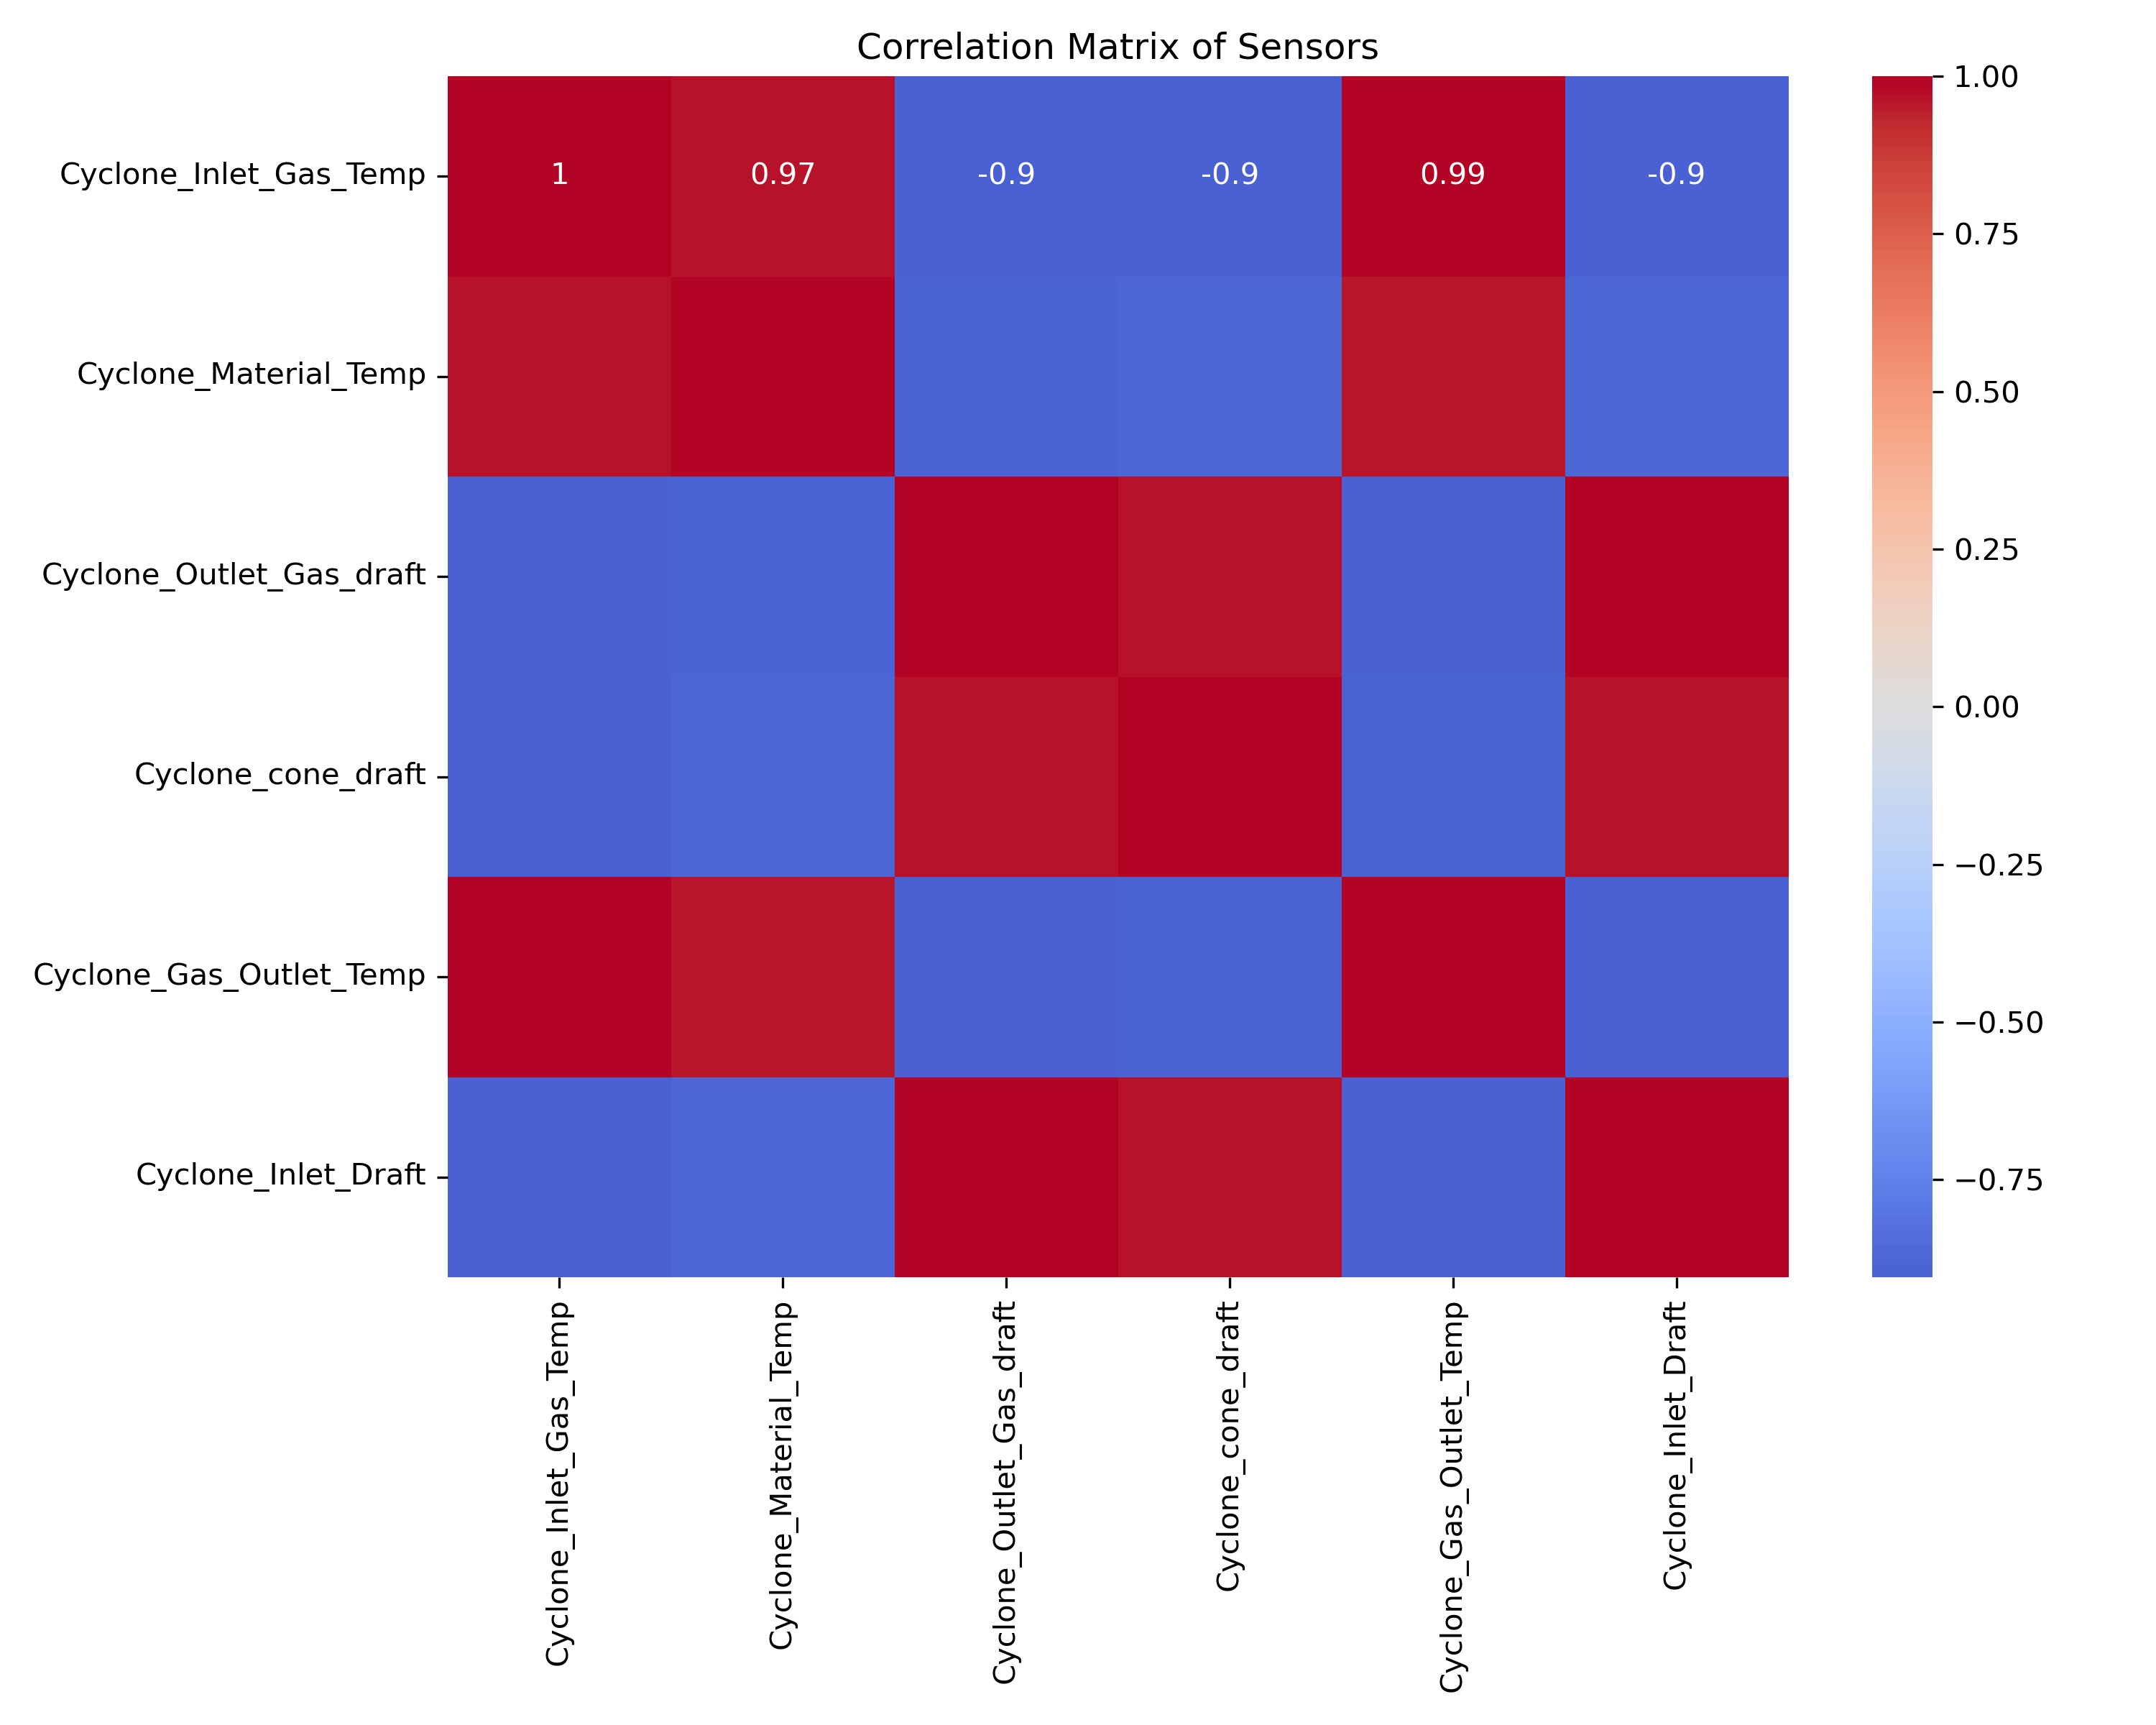

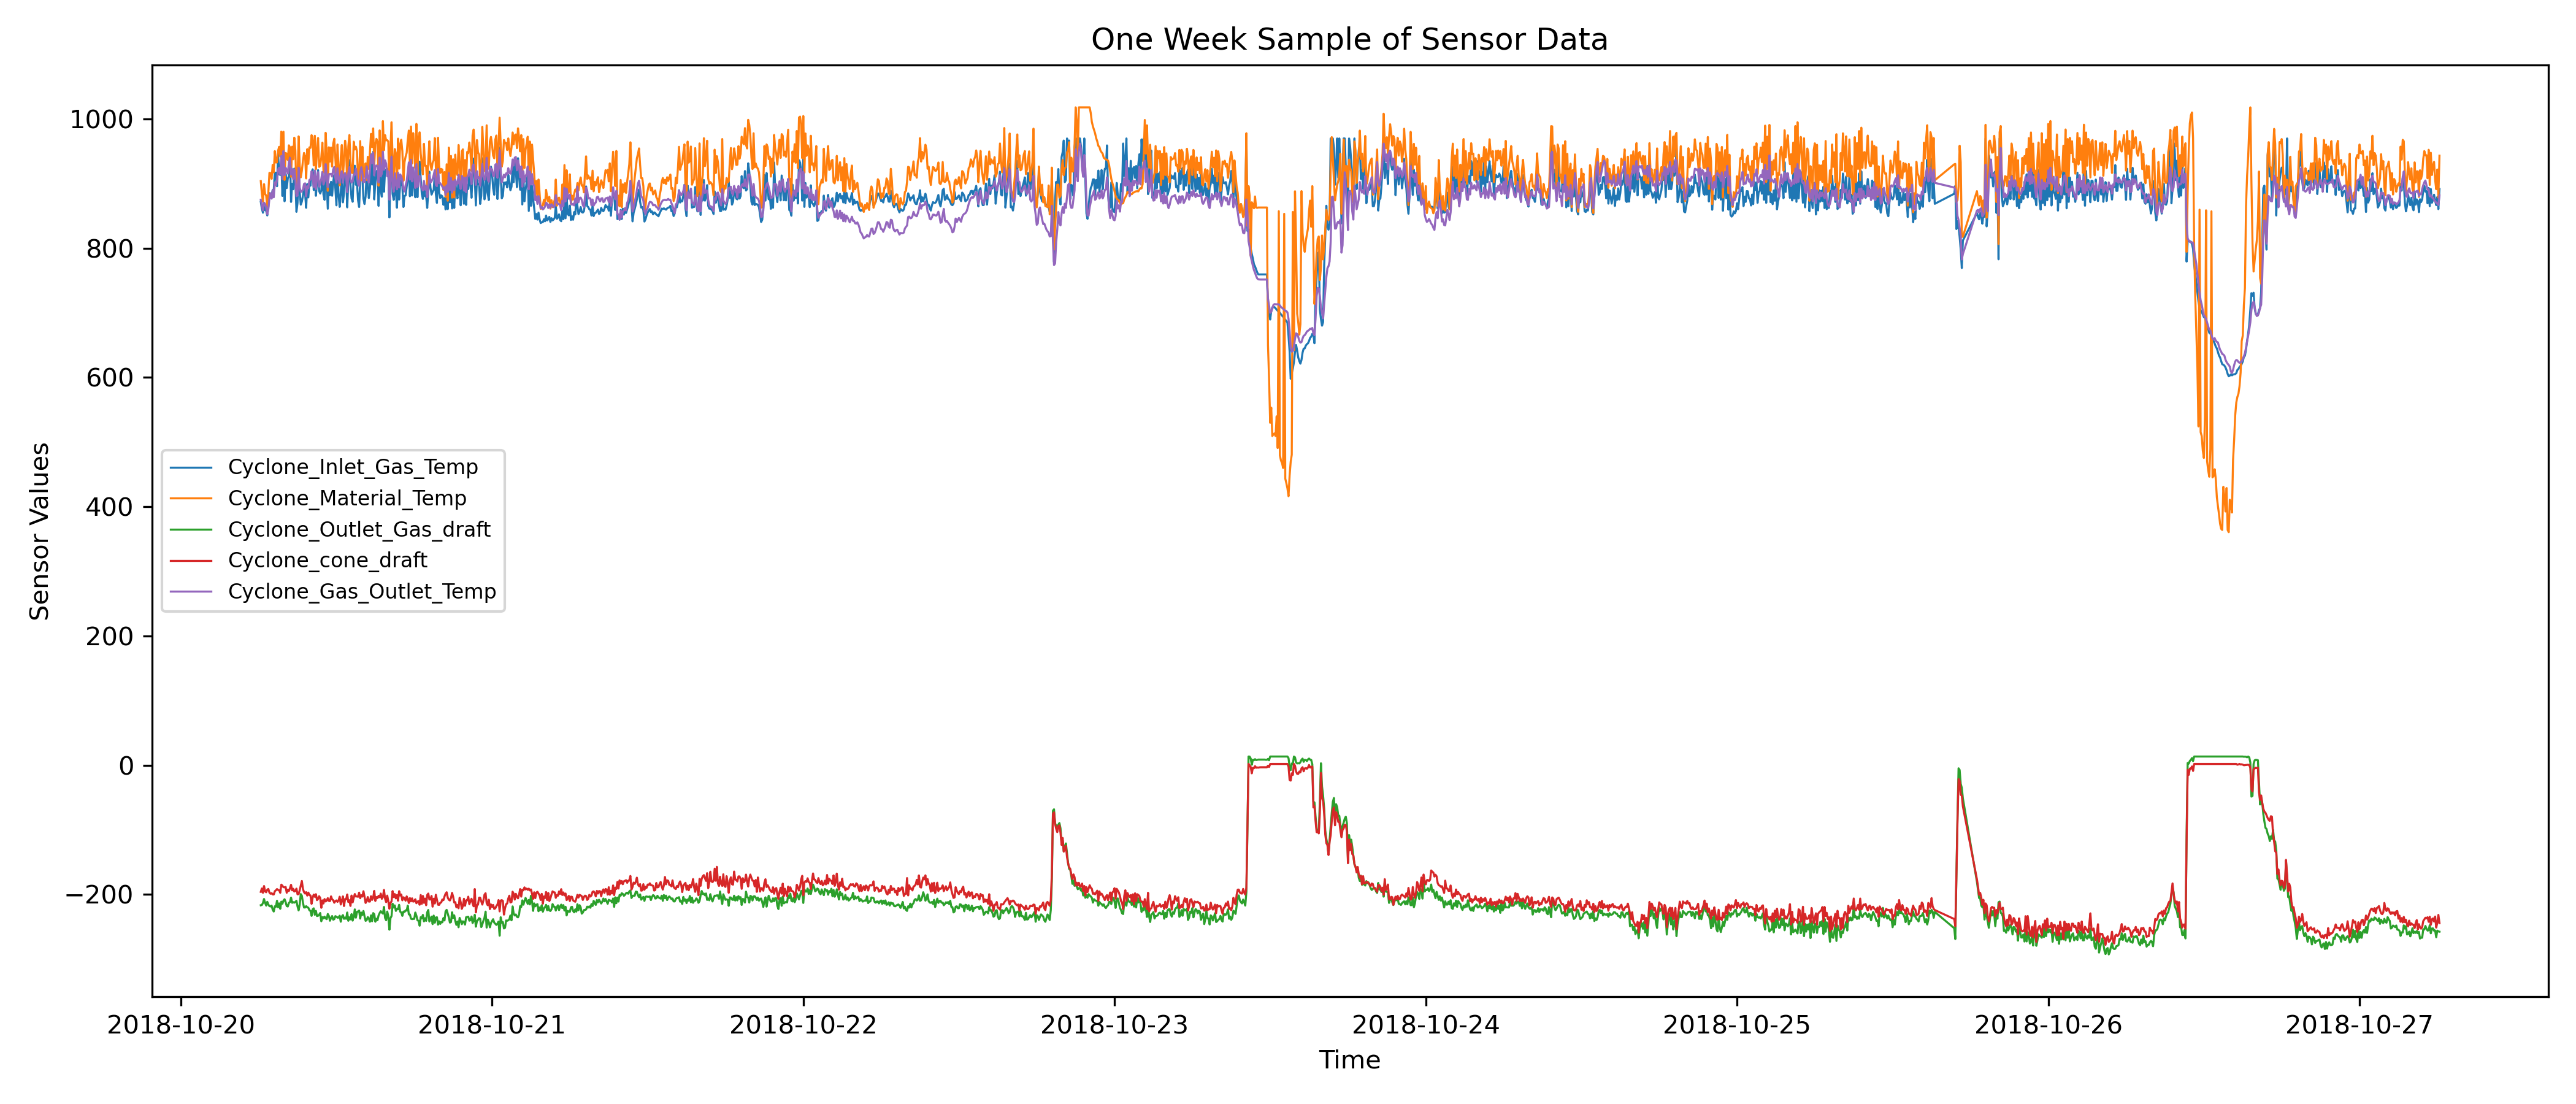

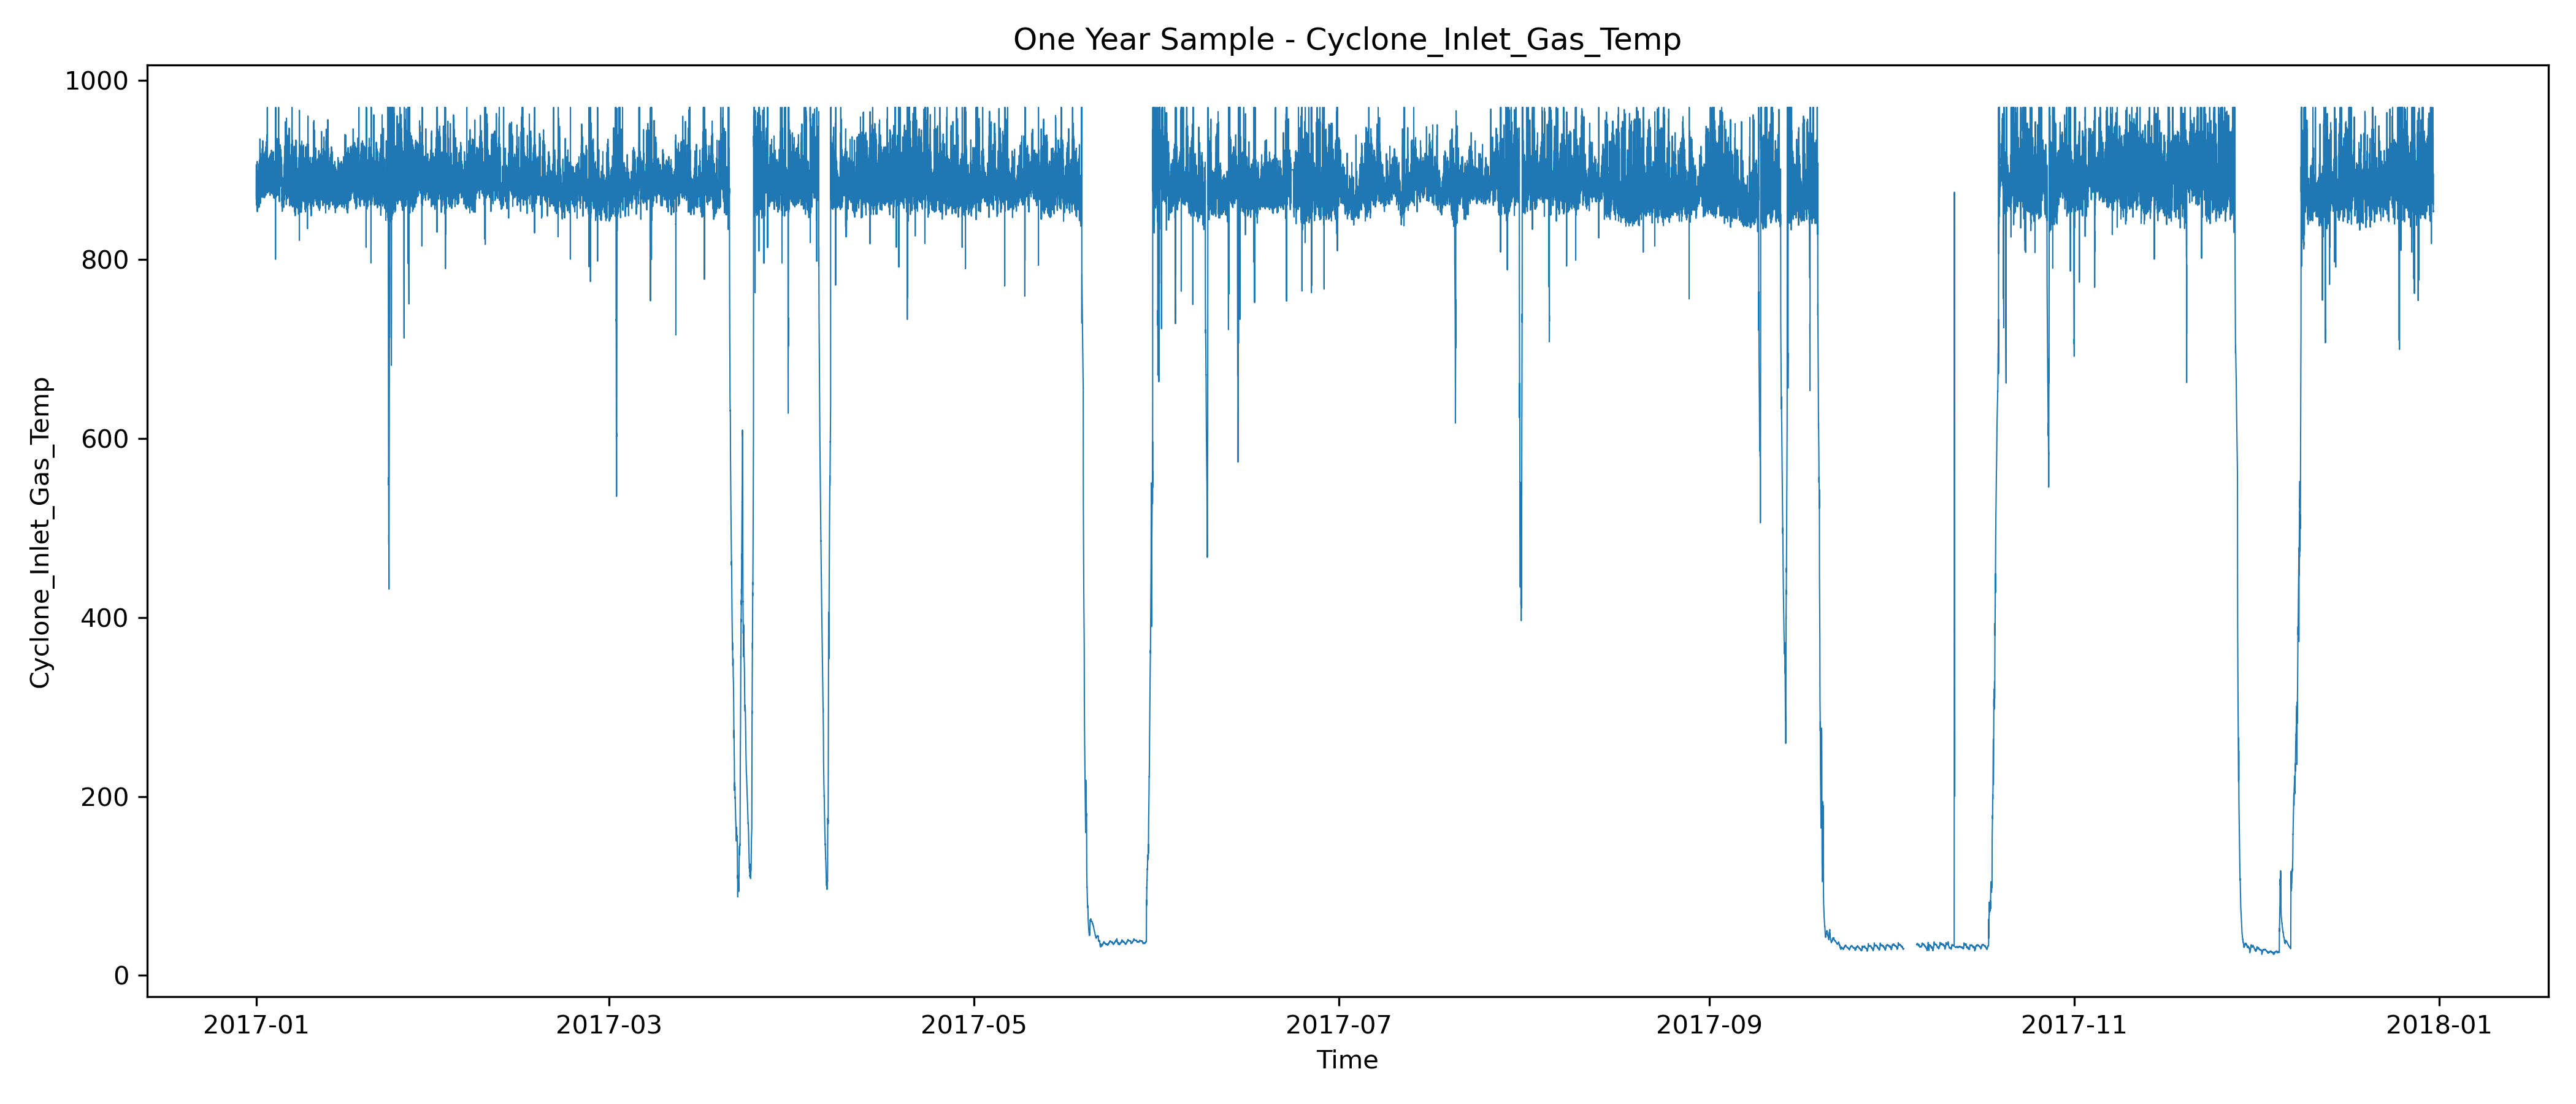

In [5]:
from IPython.display import Image, display

# Show correlation heatmap
display(Image(filename="plots/correlation_matrix.png"))

# Show one week visualization
display(Image(filename="plots/one_week_sample.png"))

# Show one year visualization
display(Image(filename="plots/one_year_sample.png"))


In [7]:
# =====================================================================
# Task 1.2: Shutdown / Idle Period Detection
# =====================================================================

import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import os

os.makedirs("outputs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Assume df is already cleaned and indexed at 5-min intervals from Part 1
# If not, reload your prepared DataFrame here

def detect_shutdowns(df, min_duration_minutes=60):
    """
    Detect shutdown periods based on low inlet/outlet temperatures and drafts.
    """
    print("\n[Shutdown Detection] Running...")

    # Define shutdown condition (adjust thresholds to your machine)
    shutdown_mask = (
        (df["Cyclone_Inlet_Gas_Temp"] < 200) &
        (df["Cyclone_Gas_Outlet_Temp"] < 200)
    )

    df["is_shutdown"] = shutdown_mask

    # Group continuous shutdowns
    df["shutdown_group"] = (df["is_shutdown"] != df["is_shutdown"].shift()).cumsum()

    shutdown_periods = []
    for g, group in df.groupby("shutdown_group"):
        if group["is_shutdown"].iloc[0]:  # true shutdown
            start = group.index.min()
            end = group.index.max()
            duration_min = len(group) * 5
            if duration_min >= min_duration_minutes:  # filter short blips
                shutdown_periods.append({
                    "start": start,
                    "end": end,
                    "duration_minutes": duration_min
                })

    shutdowns_df = pd.DataFrame(shutdown_periods)
    shutdowns_df.to_csv("outputs/shutdown_periods.csv", index=False)

    # Compute stats
    total_downtime = shutdowns_df["duration_minutes"].sum()
    num_events = len(shutdowns_df)
    print(f"✓ Detected {num_events} shutdown events")
    print(f"✓ Total downtime: {total_downtime/60:.1f} hours "
          f"({total_downtime/60/24:.1f} days)")

    # Visualization for one year
    one_year = df.loc[df.index.min(): df.index.min() + timedelta(days=365)]
    plt.figure(figsize=(15, 6))
    plt.plot(one_year.index, one_year["Cyclone_Inlet_Gas_Temp"], label="Inlet Gas Temp", color="blue")
    for _, row in shutdowns_df.iterrows():
        if row["start"].year == one_year.index[0].year:
            plt.axvspan(row["start"], row["end"], color="red", alpha=0.3)
    plt.title("Shutdowns Highlighted (First Year)")
    plt.xlabel("Time")
    plt.ylabel("Cyclone Inlet Gas Temp")
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/shutdowns_first_year.png", dpi=300)
    plt.close()

    print("✓ Saved shutdown visualization -> plots/shutdowns_first_year.png")

    return shutdowns_df


# -----------------------------
# Run shutdown detection
# -----------------------------
shutdowns_df = detect_shutdowns(df)



[Shutdown Detection] Running...
✓ Detected 35 shutdown events
✓ Total downtime: 5434.0 hours (226.4 days)
✓ Saved shutdown visualization -> plots/shutdowns_first_year.png


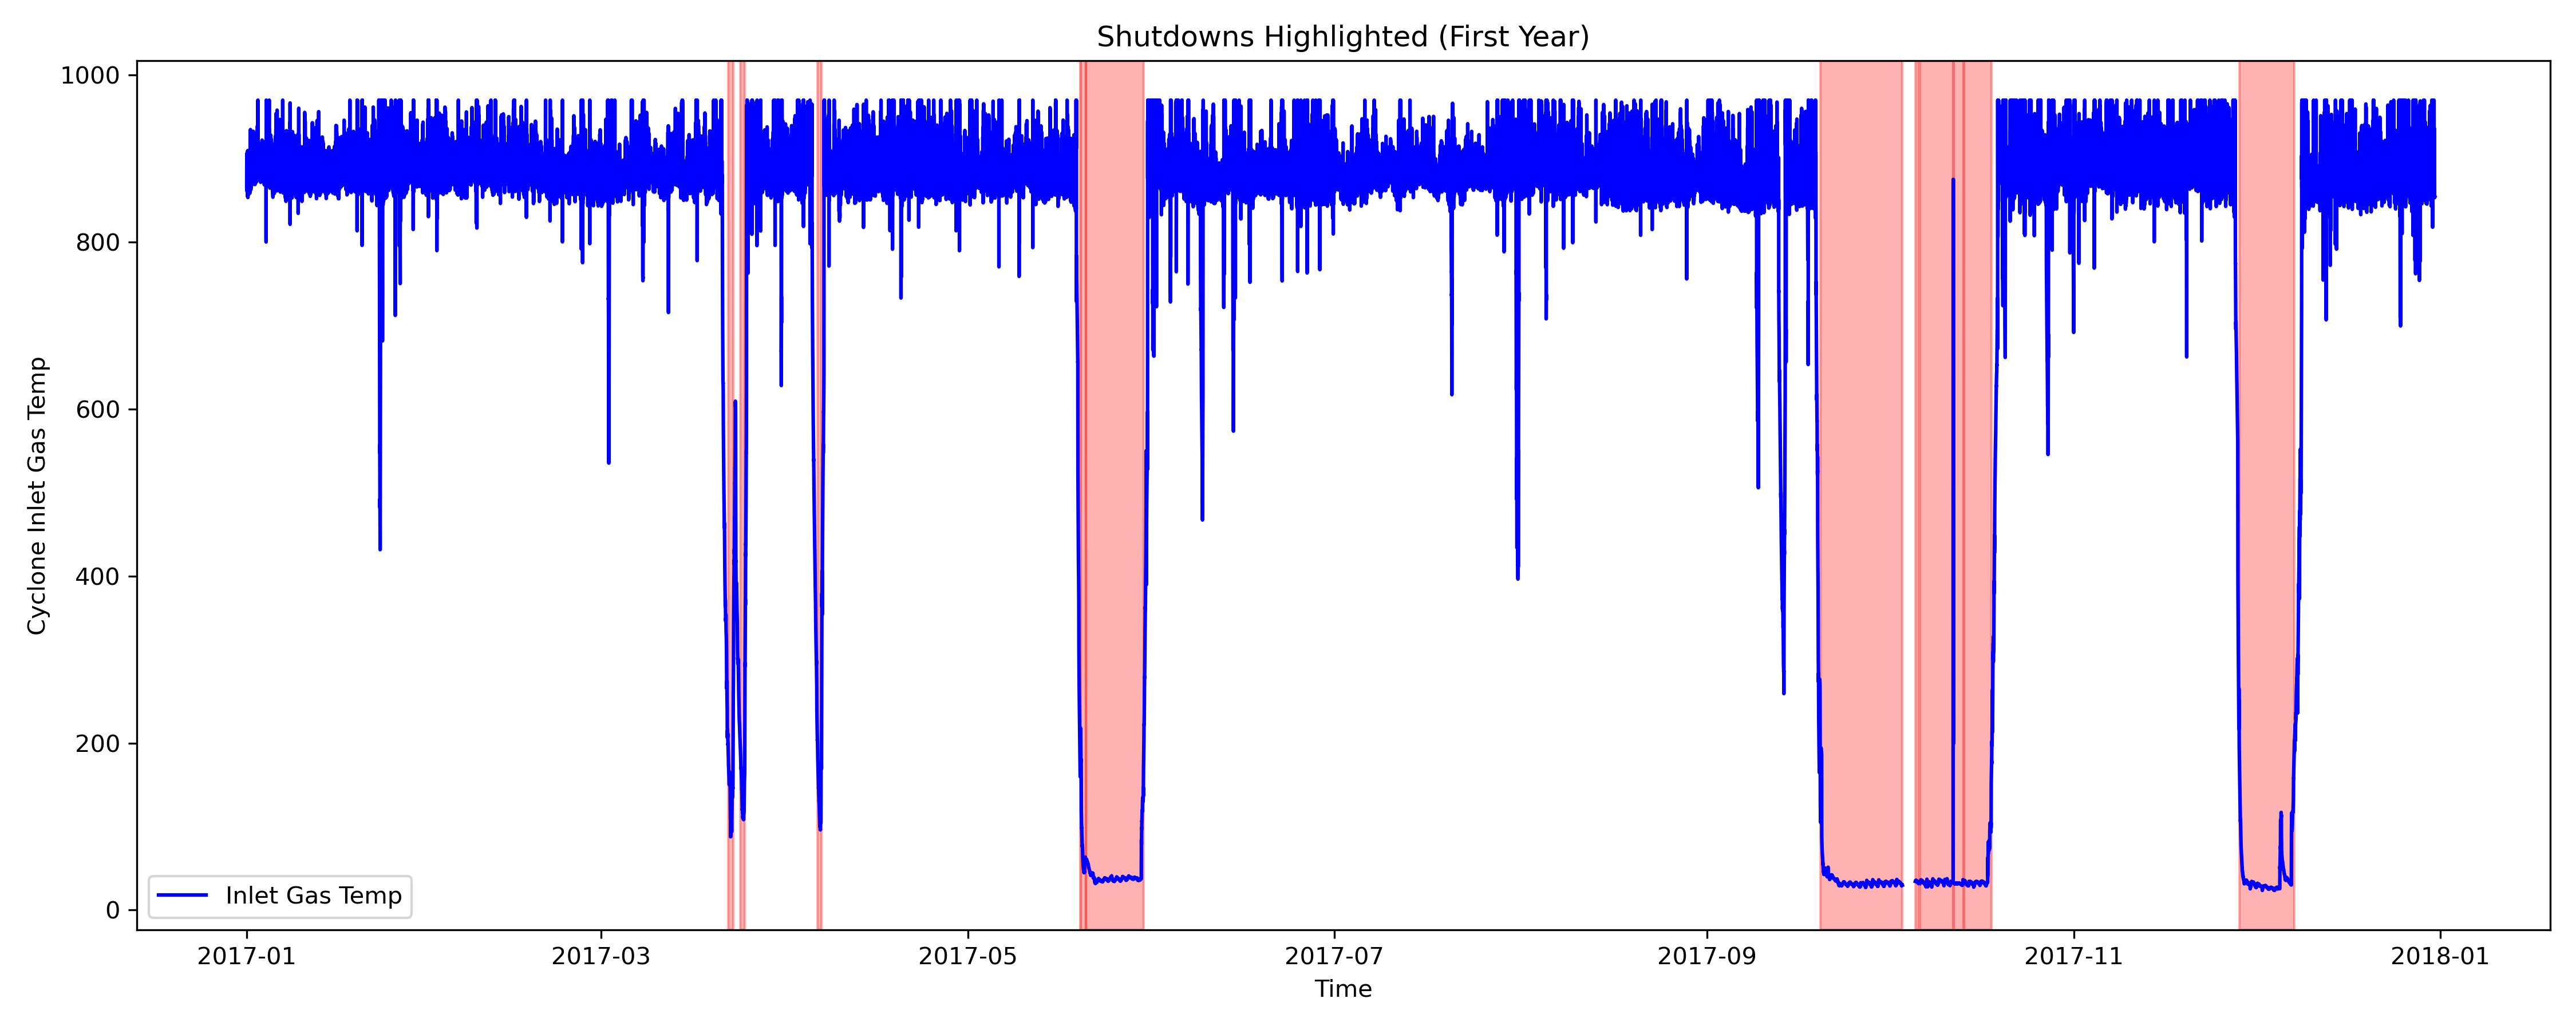

In [9]:
from IPython.display import Image
Image(filename='plots/shutdowns_first_year.png')


In [ ]:
# Full pipeline for Machine State Segmentation (Clustering)
# This notebook-style script will:
# 1. Load the provided Excel time series (first sheet).
# 2. Preprocess: parse time, convert numerics, handle missing values.
# 3. Exclude shutdown periods using a conservative heuristic (rows where *all* key signals are almost-zero or NaN).
# 4. Feature engineering: raw, lags, deltas, rolling mean/std (multiple windows).
# 5. Dimensionality reduction with PCA and scaling.
# 6. Clustering: KMeans (auto-select best k via silhouette) + optional DBSCAN/HDBSCAN if available.
# 7. Produce cluster summaries, human-readable short descriptions, frequency & duration statistics.
# 8. Save results to an Excel file and display key tables.
#
# You can tweak parameters in the "CONFIG" block below.
# Run time depends on dataset size and chosen rolling windows / PCA components.

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For display helper available in this environment
try:
    from caas_jupyter_tools import display_dataframe_to_user
except Exception:
    display_dataframe_to_user = None

# ---------- CONFIG ----------
FILE_PATH = "data.xlsx"   # input file provided by user
OUTPUT_PATH = "/mnt/data/machine_state_clustering_results.xlsx"
TIME_COLUMN = "time"               # name of time column in the file (detected if different)
MIN_ROWS_FOR_ROLL = 5              # small safety for rolling
LAG_PERIODS = [1, 3]               # lags (in rows) to compute
DELTA_PERIODS = [1]                # deltas (value - value.shift(p))
ROLL_WINDOWS = [5, 15, 60]         # rolling windows (in rows). make sure data is regularly sampled.
PCA_COMPONENTS = 6                 # number of PCA components to keep before clustering
K_RANGE = range(2, 7)              # candidate K for KMeans
SHUTDOWN_ZERO_ABS_THRESHOLD = 1e-3 # treat values whose absolute < threshold as zero (for shutdown detection)
SHUTDOWN_CONSERVATIVE = True       # if True: mark shutdown when ALL signals are near-zero/NaN; conservative choice
RANDOM_STATE = 42
# ----------------------------

# 1) Load data and inspect sheets
xls = pd.ExcelFile(FILE_PATH)
sheet_names = xls.sheet_names
df = pd.read_excel(FILE_PATH, sheet_name=sheet_names[0])

# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Detect time column if not exactly TIME_COLUMN
if TIME_COLUMN not in df.columns:
    # try common names
    for cand in ["timestamp", "Timestamp", "date", "Date", "TIME", "Time"]:
        if cand in df.columns:
            TIME_COLUMN = cand
            break

# Parse time
df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN], errors="coerce")

# Identify numeric columns (exclude time)
numeric_cols = [c for c in df.columns if c != TIME_COLUMN]

# Convert to numeric (coerce errors -> NaN)
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Sort by time if available
if df[TIME_COLUMN].notna().any():
    df = df.sort_values(TIME_COLUMN).reset_index(drop=True)

# Basic info
n_rows, n_cols = df.shape
print(f"Loaded sheet '{sheet_names[0]}' with {n_rows} rows and {len(numeric_cols)} numeric columns.")

# 2) Exclude shutdown periods
# Heuristic: shutdown if all numeric signals are near-zero (abs < threshold) or NaN (conservative).
is_zero_like = df[numeric_cols].abs().le(SHUTDOWN_ZERO_ABS_THRESHOLD)
is_all_zero_or_na = is_zero_like.fillna(True).all(axis=1)
if SHUTDOWN_CONSERVATIVE:
    shutdown_mask = is_all_zero_or_na
else:
    # alternative: mark shutdown when most signals are zero-like
    shutdown_mask = is_zero_like.fillna(True).sum(axis=1) >= (0.8 * len(numeric_cols))

n_shutdown = int(shutdown_mask.sum())
print(f"Marked {n_shutdown} rows as shutdown (excluded from clustering).")

# Keep active data
df_active = df.loc[~shutdown_mask].copy().reset_index(drop=True)

if df_active.empty:
    raise RuntimeError("No active rows after shutdown exclusion. Adjust detection heuristic.")

# 3) Feature engineering
feat = df_active[[TIME_COLUMN]].copy()

# Raw features (rename to safe names)
raw_cols = numeric_cols
for c in raw_cols:
    feat[f"raw__{c}"] = df_active[c]

# Lags
for lag in LAG_PERIODS:
    for c in raw_cols:
        feat[f"lag{lag}__{c}"] = df_active[c].shift(lag)

# Deltas
for d in DELTA_PERIODS:
    for c in raw_cols:
        feat[f"delta{d}__{c}"] = df_active[c] - df_active[c].shift(d)

# Rolling stats
for w in ROLL_WINDOWS:
    if len(df_active) >= max(MIN_ROWS_FOR_ROLL, w):
        for c in raw_cols:
            feat[f"rollmean{w}__{c}"] = df_active[c].rolling(window=w, min_periods=1).mean()
            feat[f"rollstd{w}__{c}"] = df_active[c].rolling(window=w, min_periods=1).std().fillna(0)
    else:
        print(f"Skipping roll window {w} because dataset is too short.")

# Drop rows with NaN introduced by lags/deltas at top
feat = feat.dropna().reset_index(drop=True)
print(f"After feature engineering and dropping NaNs, {len(feat)} rows remain for clustering.")

# Keep mapping to original df_active indices
feat_index = feat.index
orig_index = df_active.loc[feat.index].index

# 4) Scaling + PCA
X = feat.drop(columns=[TIME_COLUMN]).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to reduce dimensionality for clustering
pca = PCA(n_components=min(PCA_COMPONENTS, X_scaled.shape[1]), random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.cumsum()
print(f"PCA retained {pca.n_components_} components, cumulative explained variance: {explained[-1]:.3f}")

# 5) Clustering: KMeans selection by silhouette
best_k = None
best_score = -1
best_kmeans = None
best_labels = None

for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_pca)
    # silhouette requires at least 2 clusters and < n_samples clusters
    if len(set(labels)) > 1 and len(set(labels)) < len(labels):
        score = silhouette_score(X_pca, labels)
    else:
        score = -1
    print(f"KMeans k={k} => silhouette={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_kmeans = km
        best_labels = labels

print(f"Selected KMeans k={best_k} with silhouette={best_score:.4f}")

# Fit DBSCAN as alternative clustering (useful for discovering noise)
db_labels = None
try:
    db = DBSCAN(eps=0.5, min_samples=5)
    db_labels = db.fit_predict(X_pca)
    print(f"DBSCAN produced {len(set(db_labels))} clusters (including noise label -1).")
except Exception as e:
    print("DBSCAN not available or failed:", e)

# Try HDBSCAN if installed (optional)
hdb_labels = None
try:
    import hdbscan
    hdb = hdbscan.HDBSCAN(min_cluster_size=50)
    hdb_labels = hdb.fit_predict(X_pca)
    print(f"HDBSCAN produced {len(set(hdb_labels))} clusters (including -1 for noise).")
except Exception:
    hdb_labels = None

# Choose final labels (prefer HDBSCAN > DBSCAN > KMeans if available and yields useful clusters)
final_method = "kmeans"
final_labels = best_labels
if hdb_labels is not None and len(set(hdb_labels)) > 1:
    final_method = "hdbscan"
    final_labels = hdb_labels
elif db_labels is not None and len(set(db_labels)) > 1 and (hdb_labels is None):
    final_method = "dbscan"
    final_labels = db_labels

print(f"Final clustering method: {final_method} with {len(set(final_labels))} clusters.")

# Attach labels back to df_active aligned with feat rows
df_clustered = df_active.loc[feat.index].copy().reset_index(drop=True)
df_clustered["cluster"] = final_labels

# 6) Cluster summaries
def cluster_summary(dfc, numeric_cols):
    summaries = []
    for cl in sorted(dfc["cluster"].unique()):
        sub = dfc[dfc["cluster"] == cl]
        desc = {
            "cluster": int(cl),
            "count": len(sub),
            "fraction": len(sub) / len(dfc),
        }
        # per-column stats: mean/std/25/50/75
        for c in numeric_cols:
            desc[f"{c}__mean"] = sub[c].mean()
            desc[f"{c}__std"] = sub[c].std()
            desc[f"{c}__25"] = sub[c].quantile(0.25)
            desc[f"{c}__50"] = sub[c].quantile(0.5)
            desc[f"{c}__75"] = sub[c].quantile(0.75)
        summaries.append(desc)
    return pd.DataFrame(summaries)

cluster_stats = cluster_summary(df_clustered, numeric_cols)

# Short human-readable descriptions:
# We'll create simple labels by comparing cluster means to global percentiles for a few key signals.
key_signals = numeric_cols[:3] if len(numeric_cols) >= 3 else numeric_cols
global_pcts = df_clustered[key_signals].quantile([0.25,0.5,0.75]).T

def describe_cluster(dfc, cluster_id):
    sub = dfc[dfc["cluster"] == cluster_id]
    parts = []
    for c in key_signals:
        m = sub[c].mean()
        p25, p50, p75 = global_pcts.loc[c, 0.25], global_pcts.loc[c, 0.5], global_pcts.loc[c, 0.75]
        if m >= p75:
            parts.append(f"{c}: high")
        elif m >= p50:
            parts.append(f"{c}: above typical")
        elif m >= p25:
            parts.append(f"{c}: below typical")
        else:
            parts.append(f"{c}: low")
    return "; ".join(parts)

cluster_descriptions = []
for cl in sorted(df_clustered["cluster"].unique()):
    cluster_descriptions.append({
        "cluster": int(cl),
        "short_description": describe_cluster(df_clustered, cl)
    })
cluster_descriptions = pd.DataFrame(cluster_descriptions)

# 7) Frequency and duration statistics
# We compute contiguous runs of the same cluster, getting durations (in number of rows and time if time column exists)
runs = []
current_cluster = None
current_start_idx = None

for idx, row in df_clustered.reset_index().iterrows():
    cl = row["cluster"]
    if current_cluster is None:
        current_cluster = cl
        current_start_idx = idx
    elif cl != current_cluster:
        # close run
        start = current_start_idx
        end = idx - 1
        span = end - start + 1
        start_time = df_clustered.loc[start, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
        end_time = df_clustered.loc[end, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
        duration_seconds = None
        if start_time is not None and end_time is not None and pd.notna(start_time) and pd.notna(end_time):
            duration_seconds = (end_time - start_time).total_seconds()
        runs.append({"cluster": int(current_cluster), "start_idx": start, "end_idx": end, "span_rows": span,
                     "start_time": start_time, "end_time": end_time, "duration_seconds": duration_seconds})
        current_cluster = cl
        current_start_idx = idx
# close final run
if current_cluster is not None and current_start_idx is not None:
    start = current_start_idx
    end = idx
    span = end - start + 1
    start_time = df_clustered.loc[start, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    end_time = df_clustered.loc[end, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    duration_seconds = None
    if start_time is not None and end_time is not None and pd.notna(start_time) and pd.notna(end_time):
        duration_seconds = (end_time - start_time).total_seconds()
    runs.append({"cluster": int(current_cluster), "start_idx": start, "end_idx": end, "span_rows": span,
                 "start_time": start_time, "end_time": end_time, "duration_seconds": duration_seconds})

runs_df = pd.DataFrame(runs)
if not runs_df.empty:
    freq_stats = runs_df.groupby("cluster").agg(
        runs_count=("span_rows", "count"),
        avg_span_rows=("span_rows", "mean"),
        median_span_rows=("span_rows", "median"),
        avg_duration_seconds=("duration_seconds", lambda x: np.nanmean(x.dropna()) if x.notna().any() else np.nan),
        median_duration_seconds=("duration_seconds", lambda x: np.nanmedian(x.dropna()) if x.notna().any() else np.nan)
    ).reset_index()
else:
    freq_stats = pd.DataFrame(columns=["cluster", "runs_count", "avg_span_rows", "median_span_rows", "avg_duration_seconds", "median_duration_seconds"])

# 8) Save results to Excel with multiple sheets
with pd.ExcelWriter(OUTPUT_PATH) as writer:
    df.to_excel(writer, sheet_name="raw_all", index=False)
    df_active.to_excel(writer, sheet_name="raw_active", index=False)
    df_clustered.to_excel(writer, sheet_name="clustered_rows", index=False)
    cluster_stats.to_excel(writer, sheet_name="cluster_stats", index=False)
    cluster_descriptions.to_excel(writer, sheet_name="cluster_descriptions", index=False)
    runs_df.to_excel(writer, sheet_name="cluster_runs", index=False)
    freq_stats.to_excel(writer, sheet_name="cluster_run_stats", index=False)

print(f"Saved results to: {OUTPUT_PATH}")

# Display top-level summaries
summary_tables = {
    "cluster_counts": df_clustered["cluster"].value_counts().rename_axis("cluster").reset_index(name="count"),
    "cluster_stats_sample": cluster_stats.head(20),
    "cluster_descriptions": cluster_descriptions,
    "cluster_run_stats": freq_stats
}

# Use interactive display if available
if display_dataframe_to_user is not None:
    for name, table in summary_tables.items():
        try:
            display_dataframe_to_user(name, table)
        except Exception:
            print(f"Unable to use display_dataframe_to_user for {name}.")
else:
    for name, table in summary_tables.items():
        print(f"\n=== {name} ===")
        print(table.head(10).to_string(index=False))
#!/usr/bin/env python3
"""
Contextual Anomaly Detection + Root Cause Analysis
- Expects 'data.xlsx' (first sheet) or configure FILE_PATH.
- Builds cluster-specific anomaly detectors (IsolationForest / LOF).
- Produces anomaly events with implicated variables and root-cause-style hypotheses.
- Saves an Excel workbook and PNG visualizations for selected anomalies.
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
FILE_PATH = "data.xlsx"                       # input
OUTPUT_XLSX = "anomaly_rca_results.xlsx"
PLOT_FOLDER = "anomaly_plots"
TIME_COLUMN_GUESSES = ["time", "timestamp", "Timestamp", "date", "Date"]
# feature engineering
LAG_PERIODS = [1, 3]
DELTA_PERIODS = [1]
ROLL_WINDOWS = [5, 15, 60]
# clustering
PCA_COMPONENTS = 6
K_RANGE = range(2, 7)
RANDOM_STATE = 42
# anomaly detection per-cluster
USE_ISOFOREST = True
ISO_N_ESTIMATORS = 200
ISO_CONTAMINATION = "auto"   # or use float like 0.01
USE_LOF = False              # optional additional method
LOF_N_NEIGHBORS = 20
# event selection for deep RCA
TOP_N_ANOMALIES = 6
# thresholds & heuristics
IMPLICATED_VARS_TOPK = 5     # number of variables to list as implicated by magnitude
MIN_RUN_LENGTH = 1           # minimal contiguous anomaly rows to form an event
# ----------------------------------------

Path(PLOT_FOLDER).mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def load_excel_safe(filepath):
    xls = pd.ExcelFile(filepath)
    sheet = xls.sheet_names[0]
    sample = pd.read_excel(filepath, sheet_name=sheet, nrows=10, dtype=str)
    sample.columns = [c.strip() for c in sample.columns]
    valid_cols = [c for c in sample.columns if sample[c].dropna().astype(str).str.strip().any()]
    # guess time column
    time_col = None
    for cand in TIME_COLUMN_GUESSES:
        if cand in valid_cols:
            time_col = cand
            break
    if time_col:
        df = pd.read_excel(filepath, sheet_name=sheet, usecols=valid_cols, parse_dates=[time_col], engine="openpyxl")
    else:
        df = pd.read_excel(filepath, sheet_name=sheet, usecols=valid_cols, engine="openpyxl")
    df.columns = [c.strip() for c in df.columns]
    if time_col and time_col in df.columns:
        return df.sort_values(time_col).reset_index(drop=True), time_col
    # else try to auto-detect
    for c in df.columns:
        try:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().sum() > 0:
                df[c] = dt
                return df.sort_values(c).reset_index(drop=True), c
        except Exception:
            continue
    # fallback
    return df.reset_index(drop=True), None

def feature_engineer(df, time_col, numeric_cols):
    # produce dataframe 'feat' aligned with df (will drop rows with NaNs from lags)
    feat = pd.DataFrame()
    if time_col:
        feat[time_col] = df[time_col].values
    for c in numeric_cols:
        feat[f"raw__{c}"] = df[c].values
    for lag in LAG_PERIODS:
        for c in numeric_cols:
            feat[f"lag{lag}__{c}"] = df[c].shift(lag).values
    for d in DELTA_PERIODS:
        for c in numeric_cols:
            feat[f"delta{d}__{c}"] = (df[c] - df[c].shift(d)).values
    for w in ROLL_WINDOWS:
        if len(df) >= w:
            for c in numeric_cols:
                feat[f"rollmean{w}__{c}"] = df[c].rolling(window=w, min_periods=1).mean().values
                feat[f"rollstd{w}__{c}"] = df[c].rolling(window=w, min_periods=1).std().fillna(0).values
    feat = feat.dropna().reset_index(drop=True)
    return feat

def cluster_pipeline(feat, time_col):
    # Scale and PCA
    X = feat.drop(columns=[time_col]).values if time_col in feat.columns else feat.values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=min(PCA_COMPONENTS, Xs.shape[1]), random_state=RANDOM_STATE)
    Xp = pca.fit_transform(Xs)
    # choose K via silhouette
    best_k, best_score, best_labels = None, -1, None
    for k in K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(Xp)
        if len(set(labels)) > 1:
            score = silhouette_score(Xp, labels)
        else:
            score = -1
        if score > best_score:
            best_score, best_k, best_labels = score, k, labels
    print(f"Chose K={best_k} (silhouette={best_score:.3f})")
    return best_labels, scaler, pca

# ---------- Main ----------
df, TIME_COLUMN = load_excel_safe(FILE_PATH)
print(f"Loaded data {df.shape}, time_col={TIME_COLUMN}")
# numeric columns
numeric_cols = [c for c in df.columns if c != TIME_COLUMN]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------------- exclude shutdowns (conservative: all signals ~ 0) ----------------
zero_thresh = 1e-3
is_zero_like = df[numeric_cols].abs().le(zero_thresh)
shutdown_mask = is_zero_like.fillna(True).all(axis=1)   # conservative
print(f"Excluding {shutdown_mask.sum()} shutdown rows")
df_active = df.loc[~shutdown_mask].reset_index(drop=True)
if df_active.empty:
    raise RuntimeError("No active rows after shutdown exclusion. Adjust rules.")

# ---------------- feature engineering ----------------
feat = feature_engineer(df_active, TIME_COLUMN, numeric_cols)
print(f"Feature matrix shape after engineering: {feat.shape}")

# ---------------- clustering ----------------
labels, scaler, pca = cluster_pipeline(feat, TIME_COLUMN)
feat["cluster"] = labels
df_clustered = df_active.loc[feat.index].reset_index(drop=True).copy()
df_clustered["cluster"] = labels

# make cluster-level statistics
cluster_stats = df_clustered.groupby("cluster")[numeric_cols].agg(["mean","std","median","count"])
cluster_means = cluster_stats.xs("mean", axis=1, level=1)
cluster_stds = cluster_stats.xs("std", axis=1, level=1)

# ---------------- per-cluster anomaly detectors ----------------
# Store anomaly scores in dataframe (aligned with feat / df_clustered)
feat_idx = feat.index
anomaly_scores = pd.Series(index=feat_idx, dtype=float)
anomaly_methods = {}  # store per-cluster models

for cl in sorted(feat["cluster"].unique()):
    mask = feat["cluster"] == cl
    X_cluster = feat.loc[mask].drop(columns=[TIME_COLUMN,"cluster"]).values
    if X_cluster.shape[0] < 10:
        # too few points, skip training; mark scores as 0 (not anomalous) or use a simple z-score method
        print(f"Cluster {cl}: too few samples ({len(X_cluster)}), using z-score fallback")
        # compute Mahalanobis-like z-score fallback using per-feature zscores computed on df_clustered numeric cols
        # We'll compute a simple aggregated abs z across numeric_cols
        cluster_mean = cluster_means.loc[cl].values
        cluster_std = cluster_stds.loc[cl].replace(0, 1e-6).loc[cl].values if False else cluster_stds.loc[cl].values
        # fallback: compute z for raw numeric cols subset
        X_raw = df_clustered.loc[mask, numeric_cols].values
        z = np.abs((X_raw - cluster_mean) / np.where(cluster_std==0,1e-6,cluster_std))
        agg = np.nanmean(z, axis=1)
        anomaly_scores.loc[mask.index] = agg
        anomaly_methods[cl] = {"method": "z-fallback"}
        continue

    # standardize
    scaler_local = StandardScaler()
    Xc_scaled = scaler_local.fit_transform(X_cluster)

    scores_cl = np.zeros(Xc_scaled.shape[0])
    if USE_ISOFOREST:
        iso = IsolationForest(n_estimators=ISO_N_ESTIMATORS, contamination=ISO_CONTAMINATION, random_state=RANDOM_STATE)
        iso.fit(Xc_scaled)
        # sklearn's IsolationForest: the lower (more negative) the score_samples -> more anomalous
        iso_score = -iso.score_samples(Xc_scaled)   # invert so higher = more anomalous
        scores_cl += iso_score
        anomaly_methods[cl] = {"iforest": iso}
    if USE_LOF:
        lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=0.05, novelty=False)
        lof_labels_scores = lof.fit_predict(Xc_scaled)
        # LocalOutlierFactor negative_outlier_factor_ : lower -> more anomalous
        lof_score = -lof.negative_outlier_factor_
        scores_cl += lof_score
        anomaly_methods.setdefault(cl, {})["lof"] = lof

    # normalize cluster scores to mean=0, std=1 then attach
    if np.std(scores_cl) == 0:
        scores_cl_norm = scores_cl
    else:
        scores_cl_norm = (scores_cl - np.mean(scores_cl)) / np.std(scores_cl)
    # place into global series aligned with indices
    anomaly_scores.loc[mask.index] = scores_cl_norm

# Attach anomaly score to df_clustered
df_clustered = df_clustered.loc[feat.index].reset_index(drop=True)
df_clustered["anomaly_score"] = anomaly_scores.values

# ---------------- Flag anomalies (thresholding)
# We pick points with anomaly_score >= threshold. Threshold can be e.g. 2 std dev above cluster mean (global standardized above)
THRESH = 2.0
df_clustered["is_anomaly"] = df_clustered["anomaly_score"] >= THRESH

# ---------------- Aggregate contiguous anomaly rows into events
events = []
in_event = False
for i, row in df_clustered.reset_index().iterrows():
    is_a = bool(row["is_anomaly"])
    if is_a and not in_event:
        in_event = True
        start_idx = i
        start_time = row[TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    elif (not is_a) and in_event:
        end_idx = i - 1
        end_time = df_clustered.loc[end_idx, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
        span = end_idx - start_idx + 1
        events.append({"start_idx": start_idx, "end_idx": end_idx, "span_rows": span,
                       "start_time": start_time, "end_time": end_time})
        in_event = False
# close if open
if in_event:
    end_idx = i
    end_time = df_clustered.loc[end_idx, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    span = end_idx - start_idx + 1
    events.append({"start_idx": start_idx, "end_idx": end_idx, "span_rows": span,
                   "start_time": start_time, "end_time": end_time})

events_df = pd.DataFrame(events)
if not events_df.empty and TIME_COLUMN in df_clustered.columns:
    events_df["duration_seconds"] = (events_df["end_time"] - events_df["start_time"]).dt.total_seconds()
else:
    events_df["duration_seconds"] = events_df["span_rows"]  # fallback

# ---------------- For each event, find implicated variables
def implicated_variables_for_event(dfc, numeric_cols, ev, topk=5):
    sub = dfc.loc[ev["start_idx"]:ev["end_idx"]]
    # compute cluster means & stds based on the cluster (we use cluster label of majority rows)
    cl = int(sub["cluster"].mode().iloc[0])
    mean = cluster_means.loc[cl].values
    std = cluster_stds.loc[cl].values
    std_safe = np.where(std == 0, 1e-6, std)
    # for each variable compute max absolute z in event and mean delta magnitude
    z_scores = np.abs((sub[numeric_cols] - mean) / std_safe)
    max_abs_z = z_scores.max(axis=0)
    # compute average delta magnitude relative to previous sample outside event (if available)
    # we'll compute delta = event first row - previous row
    prev_idx = max(ev["start_idx"] - 1, 0)
    deltas = (sub.iloc[0][numeric_cols] - dfc.iloc[prev_idx][numeric_cols]).abs()
    # combine ranking: prioritize large max_abs_z then large delta
    rank_score = max_abs_z.values * 0.7 + (deltas.values / (np.nanmax(deltas.values)+1e-9)) * 0.3
    idx_sorted = np.argsort(-rank_score)[:topk]
    implicated = [{"var": numeric_cols[i], "max_abs_z": float(max_abs_z.values[i]), "delta_from_prev": float(deltas.values[i])} for i in idx_sorted]
    return cl, implicated

implicated_list = []
for _, ev in events_df.iterrows():
    cl, implicated = implicated_variables_for_event(df_clustered, numeric_cols, ev, topk=IMPLICATED_VARS_TOPK)
    implicated_list.append({"cluster": int(cl), "implicated": implicated})
events_df = pd.concat([events_df.reset_index(drop=True), pd.DataFrame(implicated_list)], axis=1)

# ---------------- Consolidated anomalous events list
events_df_sorted = events_df.sort_values(["duration_seconds"], ascending=False).reset_index(drop=True)
print(f"Detected {len(events_df_sorted)} anomaly events (threshold={THRESH}).")

# ---------------- Select top N anomalies for RCA and visualization
top_events = events_df_sorted.head(TOP_N_ANOMALIES).copy()

def make_rca_for_event(dfc, ev, numeric_cols, top_implicated):
    sub = dfc.loc[ev["start_idx"]:ev["end_idx"]]
    cl_before = int(dfc.loc[max(ev["start_idx"]-1,0),"cluster"])
    cl_during = int(sub["cluster"].mode().iloc[0])
    # simplistic reasoning heuristics:
    reasons = []
    # check if cluster changed before/after
    if cl_before != cl_during:
        reasons.append(f"State changed from cluster {cl_before} → {cl_during} around anomaly start; could be state transition related.")
    # examine implicated variables for sudden spikes or drops
    for imp in top_implicated:
        var = imp["var"]; z = imp["max_abs_z"]; delta = imp["delta_from_prev"]
        sign = "up" if delta > 0 else "down" if delta < 0 else "no-change"
        if abs(delta) > 0:
            reasons.append(f"{var} had a sudden {sign} (delta ≈ {delta:.2f}; max |z| ≈ {z:.2f}).")
        else:
            reasons.append(f"{var} shows anomalous magnitude (max |z| ≈ {z:.2f}).")
    # condense to hypothesis
    hypothesis = "Likely causes: " + "; ".join(reason for reason in reasons[:4])
    return hypothesis, reasons

rca_records = []
for _, ev in top_events.reset_index().iterrows():
    implicated = ev["implicated"]
    hypothesis, reasons = make_rca_for_event(df_clustered, ev, numeric_cols, implicated)
    # create visualization
    fig, ax = plt.subplots(len(numeric_cols[:6])+1, 1, sharex=True, figsize=(14, 2*(len(numeric_cols[:6])+1)))
    # top 6 variables for visibility (or fewer)
    top_vars_plot = [v["var"] for v in implicated][:6] if implicated else numeric_cols[:6]
    # plot each
    for i, var in enumerate(top_vars_plot):
        ax[i].plot(df_clustered[TIME_COLUMN], df_clustered[var], label=var)
        # highlight cluster shading
        ax[i].axvspan(ev["start_time"], ev["end_time"], color="red", alpha=0.2)
        ax[i].legend(loc="upper left")
    # add a subplot for cluster label + anomaly_score
    ax[-1].plot(df_clustered[TIME_COLUMN], df_clustered["cluster"], label="cluster", linestyle="--")
    ax2 = ax[-1].twinx()
    ax2.plot(df_clustered[TIME_COLUMN], df_clustered["anomaly_score"], label="anomaly_score", alpha=0.6)
    ax[-1].axvspan(ev["start_time"], ev["end_time"], color="red", alpha=0.2)
    ax[-1].legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.suptitle(f"Event {ev.name}: cluster={ev['cluster']} span_rows={ev['span_rows']} duration_s={ev['duration_seconds']}")
    plt.tight_layout(rect=[0,0,1,0.97])
    plot_path = f"{PLOT_FOLDER}/event_{ev.name}_cluster{ev['cluster']}_start{ev['start_time']}.png"
    plt.savefig(plot_path)
    plt.close(fig)

    rca_records.append({
        "event_index": int(ev.name),
        "start_time": ev["start_time"],
        "end_time": ev["end_time"],
        "duration_seconds": ev["duration_seconds"],
        "cluster": int(ev["cluster"]),
        "implicated_vars": ev["implicated"],
        "hypothesis": hypothesis,
        "reason_snippets": reasons
    })

# ---------------- Save results
with pd.ExcelWriter(OUTPUT_XLSX) as writer:
    df.to_excel(writer, sheet_name="raw_all", index=False)
    df_active.to_excel(writer, sheet_name="raw_active", index=False)
    df_clustered.to_excel(writer, sheet_name="clustered_rows", index=False)
    events_df.to_excel(writer, sheet_name="anomaly_events", index=False)
    pd.DataFrame(rca_records).to_excel(writer, sheet_name="rca_top_events", index=False)

print(f"Saved consolidated results to {OUTPUT_XLSX}")
print(f"Saved visualizations for top {len(rca_records)} events in {PLOT_FOLDER}/")

# Print short RCA summaries for selected events
for rec in rca_records:
    print("=== Event", rec["event_index"], "cluster", rec["cluster"], "duration_s", rec["duration_seconds"])
    print("Impacted vars:", ", ".join([f'{v["var"]} (z={v["max_abs_z"]:.2f}, Δ={v["delta_from_prev"]:.2f})' for v in rec["implicated_vars"]]))
    print("Hypothesis:", rec["hypothesis"])
    print()

# Basic plot: cluster counts
plt.figure(figsize=(6,4))
counts = summary_tables["cluster_counts"].set_index("cluster").sort_index()
counts.plot(kind="bar", legend=False)
plt.title("Cluster counts")
plt.xlabel("cluster")
plt.ylabel("count")
plt.tight_layout()
plt.savefig("/mnt/data/cluster_counts.png")
plt.show()

# Provide file path for download
print("\nOutputs saved:")
print(" - Excel results:", OUTPUT_PATH)
print(" - Cluster counts plot: /mnt/data/cluster_counts.png")

#!/usr/bin/env python3
"""
Contextual Anomaly Detection + Root Cause Analysis
- Expects 'data.xlsx' (first sheet) or configure FILE_PATH.
- Builds cluster-specific anomaly detectors (IsolationForest / LOF).
- Produces anomaly events with implicated variables and root-cause-style hypotheses.
- Saves an Excel workbook and PNG visualizations for selected anomalies.
"""

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
FILE_PATH = "data.xlsx"                       # input
OUTPUT_XLSX = "anomaly_rca_results.xlsx"
PLOT_FOLDER = "anomaly_plots"
TIME_COLUMN_GUESSES = ["time", "timestamp", "Timestamp", "date", "Date"]
# feature engineering
LAG_PERIODS = [1, 3]
DELTA_PERIODS = [1]
ROLL_WINDOWS = [5, 15, 60]
# clustering
PCA_COMPONENTS = 6
K_RANGE = range(2, 7)
RANDOM_STATE = 42
# anomaly detection per-cluster
USE_ISOFOREST = True
ISO_N_ESTIMATORS = 200
ISO_CONTAMINATION = "auto"   # or use float like 0.01
USE_LOF = False              # optional additional method
LOF_N_NEIGHBORS = 20
# event selection for deep RCA
TOP_N_ANOMALIES = 6
# thresholds & heuristics
IMPLICATED_VARS_TOPK = 5     # number of variables to list as implicated by magnitude
MIN_RUN_LENGTH = 1           # minimal contiguous anomaly rows to form an event
# ----------------------------------------

Path(PLOT_FOLDER).mkdir(parents=True, exist_ok=True)

# ---------- Helpers ----------
def load_excel_safe(filepath):
    xls = pd.ExcelFile(filepath)
    sheet = xls.sheet_names[0]
    sample = pd.read_excel(filepath, sheet_name=sheet, nrows=10, dtype=str)
    sample.columns = [c.strip() for c in sample.columns]
    valid_cols = [c for c in sample.columns if sample[c].dropna().astype(str).str.strip().any()]
    # guess time column
    time_col = None
    for cand in TIME_COLUMN_GUESSES:
        if cand in valid_cols:
            time_col = cand
            break
    if time_col:
        df = pd.read_excel(filepath, sheet_name=sheet, usecols=valid_cols, parse_dates=[time_col], engine="openpyxl")
    else:
        df = pd.read_excel(filepath, sheet_name=sheet, usecols=valid_cols, engine="openpyxl")
    df.columns = [c.strip() for c in df.columns]
    if time_col and time_col in df.columns:
        return df.sort_values(time_col).reset_index(drop=True), time_col
    # else try to auto-detect
    for c in df.columns:
        try:
            dt = pd.to_datetime(df[c], errors="coerce")
            if dt.notna().sum() > 0:
                df[c] = dt
                return df.sort_values(c).reset_index(drop=True), c
        except Exception:
            continue
    # fallback
    return df.reset_index(drop=True), None

def feature_engineer(df, time_col, numeric_cols):
    # produce dataframe 'feat' aligned with df (will drop rows with NaNs from lags)
    feat = pd.DataFrame()
    if time_col:
        feat[time_col] = df[time_col].values
    for c in numeric_cols:
        feat[f"raw__{c}"] = df[c].values
    for lag in LAG_PERIODS:
        for c in numeric_cols:
            feat[f"lag{lag}__{c}"] = df[c].shift(lag).values
    for d in DELTA_PERIODS:
        for c in numeric_cols:
            feat[f"delta{d}__{c}"] = (df[c] - df[c].shift(d)).values
    for w in ROLL_WINDOWS:
        if len(df) >= w:
            for c in numeric_cols:
                feat[f"rollmean{w}__{c}"] = df[c].rolling(window=w, min_periods=1).mean().values
                feat[f"rollstd{w}__{c}"] = df[c].rolling(window=w, min_periods=1).std().fillna(0).values
    feat = feat.dropna().reset_index(drop=True)
    return feat

def cluster_pipeline(feat, time_col):
    # Scale and PCA
    X = feat.drop(columns=[time_col]).values if time_col in feat.columns else feat.values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    pca = PCA(n_components=min(PCA_COMPONENTS, Xs.shape[1]), random_state=RANDOM_STATE)
    Xp = pca.fit_transform(Xs)
    # choose K via silhouette
    best_k, best_score, best_labels = None, -1, None
    for k in K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(Xp)
        if len(set(labels)) > 1:
            score = silhouette_score(Xp, labels)
        else:
            score = -1
        if score > best_score:
            best_score, best_k, best_labels = score, k, labels
    print(f"Chose K={best_k} (silhouette={best_score:.3f})")
    return best_labels, scaler, pca

# ---------- Main ----------
df, TIME_COLUMN = load_excel_safe(FILE_PATH)
print(f"Loaded data {df.shape}, time_col={TIME_COLUMN}")
# numeric columns
numeric_cols = [c for c in df.columns if c != TIME_COLUMN]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---------------- exclude shutdowns (conservative: all signals ~ 0) ----------------
zero_thresh = 1e-3
is_zero_like = df[numeric_cols].abs().le(zero_thresh)
shutdown_mask = is_zero_like.fillna(True).all(axis=1)   # conservative
print(f"Excluding {shutdown_mask.sum()} shutdown rows")
df_active = df.loc[~shutdown_mask].reset_index(drop=True)
if df_active.empty:
    raise RuntimeError("No active rows after shutdown exclusion. Adjust rules.")

# ---------------- feature engineering ----------------
feat = feature_engineer(df_active, TIME_COLUMN, numeric_cols)
print(f"Feature matrix shape after engineering: {feat.shape}")

# ---------------- clustering ----------------
labels, scaler, pca = cluster_pipeline(feat, TIME_COLUMN)
feat["cluster"] = labels
df_clustered = df_active.loc[feat.index].reset_index(drop=True).copy()
df_clustered["cluster"] = labels

# make cluster-level statistics
cluster_stats = df_clustered.groupby("cluster")[numeric_cols].agg(["mean","std","median","count"])
cluster_means = cluster_stats.xs("mean", axis=1, level=1)
cluster_stds = cluster_stats.xs("std", axis=1, level=1)

# ---------------- per-cluster anomaly detectors ----------------
# Store anomaly scores in dataframe (aligned with feat / df_clustered)
feat_idx = feat.index
anomaly_scores = pd.Series(index=feat_idx, dtype=float)
anomaly_methods = {}  # store per-cluster models

for cl in sorted(feat["cluster"].unique()):
    mask = feat["cluster"] == cl
    X_cluster = feat.loc[mask].drop(columns=[TIME_COLUMN,"cluster"]).values
    if X_cluster.shape[0] < 10:
        # too few points, skip training; mark scores as 0 (not anomalous) or use a simple z-score method
        print(f"Cluster {cl}: too few samples ({len(X_cluster)}), using z-score fallback")
        # compute Mahalanobis-like z-score fallback using per-feature zscores computed on df_clustered numeric cols
        # We'll compute a simple aggregated abs z across numeric_cols
        cluster_mean = cluster_means.loc[cl].values
        cluster_std = cluster_stds.loc[cl].replace(0, 1e-6).loc[cl].values if False else cluster_stds.loc[cl].values
        # fallback: compute z for raw numeric cols subset
        X_raw = df_clustered.loc[mask, numeric_cols].values
        z = np.abs((X_raw - cluster_mean) / np.where(cluster_std==0,1e-6,cluster_std))
        agg = np.nanmean(z, axis=1)
        anomaly_scores.loc[mask.index] = agg
        anomaly_methods[cl] = {"method": "z-fallback"}
        continue

    # standardize
    scaler_local = StandardScaler()
    Xc_scaled = scaler_local.fit_transform(X_cluster)

    scores_cl = np.zeros(Xc_scaled.shape[0])
    if USE_ISOFOREST:
        iso = IsolationForest(n_estimators=ISO_N_ESTIMATORS, contamination=ISO_CONTAMINATION, random_state=RANDOM_STATE)
        iso.fit(Xc_scaled)
        # sklearn's IsolationForest: the lower (more negative) the score_samples -> more anomalous
        iso_score = -iso.score_samples(Xc_scaled)   # invert so higher = more anomalous
        scores_cl += iso_score
        anomaly_methods[cl] = {"iforest": iso}
    if USE_LOF:
        lof = LocalOutlierFactor(n_neighbors=LOF_N_NEIGHBORS, contamination=0.05, novelty=False)
        lof_labels_scores = lof.fit_predict(Xc_scaled)
        # LocalOutlierFactor negative_outlier_factor_ : lower -> more anomalous
        lof_score = -lof.negative_outlier_factor_
        scores_cl += lof_score
        anomaly_methods.setdefault(cl, {})["lof"] = lof

    # normalize cluster scores to mean=0, std=1 then attach
    if np.std(scores_cl) == 0:
        scores_cl_norm = scores_cl
    else:
        scores_cl_norm = (scores_cl - np.mean(scores_cl)) / np.std(scores_cl)
    # place into global series aligned with indices
    anomaly_scores.loc[mask.index] = scores_cl_norm

# Attach anomaly score to df_clustered
df_clustered = df_clustered.loc[feat.index].reset_index(drop=True)
df_clustered["anomaly_score"] = anomaly_scores.values

# ---------------- Flag anomalies (thresholding)
# We pick points with anomaly_score >= threshold. Threshold can be e.g. 2 std dev above cluster mean (global standardized above)
THRESH = 2.0
df_clustered["is_anomaly"] = df_clustered["anomaly_score"] >= THRESH

# ---------------- Aggregate contiguous anomaly rows into events
events = []
in_event = False
for i, row in df_clustered.reset_index().iterrows():
    is_a = bool(row["is_anomaly"])
    if is_a and not in_event:
        in_event = True
        start_idx = i
        start_time = row[TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    elif (not is_a) and in_event:
        end_idx = i - 1
        end_time = df_clustered.loc[end_idx, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
        span = end_idx - start_idx + 1
        events.append({"start_idx": start_idx, "end_idx": end_idx, "span_rows": span,
                       "start_time": start_time, "end_time": end_time})
        in_event = False
# close if open
if in_event:
    end_idx = i
    end_time = df_clustered.loc[end_idx, TIME_COLUMN] if TIME_COLUMN in df_clustered.columns else None
    span = end_idx - start_idx + 1
    events.append({"start_idx": start_idx, "end_idx": end_idx, "span_rows": span,
                   "start_time": start_time, "end_time": end_time})

events_df = pd.DataFrame(events)
if not events_df.empty and TIME_COLUMN in df_clustered.columns:
    events_df["duration_seconds"] = (events_df["end_time"] - events_df["start_time"]).dt.total_seconds()
else:
    events_df["duration_seconds"] = events_df["span_rows"]  # fallback

# ---------------- For each event, find implicated variables
def implicated_variables_for_event(dfc, numeric_cols, ev, topk=5):
    sub = dfc.loc[ev["start_idx"]:ev["end_idx"]]
    # compute cluster means & stds based on the cluster (we use cluster label of majority rows)
    cl = int(sub["cluster"].mode().iloc[0])
    mean = cluster_means.loc[cl].values
    std = cluster_stds.loc[cl].values
    std_safe = np.where(std == 0, 1e-6, std)
    # for each variable compute max absolute z in event and mean delta magnitude
    z_scores = np.abs((sub[numeric_cols] - mean) / std_safe)
    max_abs_z = z_scores.max(axis=0)
    # compute average delta magnitude relative to previous sample outside event (if available)
    # we'll compute delta = event first row - previous row
    prev_idx = max(ev["start_idx"] - 1, 0)
    deltas = (sub.iloc[0][numeric_cols] - dfc.iloc[prev_idx][numeric_cols]).abs()
    # combine ranking: prioritize large max_abs_z then large delta
    rank_score = max_abs_z.values * 0.7 + (deltas.values / (np.nanmax(deltas.values)+1e-9)) * 0.3
    idx_sorted = np.argsort(-rank_score)[:topk]
    implicated = [{"var": numeric_cols[i], "max_abs_z": float(max_abs_z.values[i]), "delta_from_prev": float(deltas.values[i])} for i in idx_sorted]
    return cl, implicated

implicated_list = []
for _, ev in events_df.iterrows():
    cl, implicated = implicated_variables_for_event(df_clustered, numeric_cols, ev, topk=IMPLICATED_VARS_TOPK)
    implicated_list.append({"cluster": int(cl), "implicated": implicated})
events_df = pd.concat([events_df.reset_index(drop=True), pd.DataFrame(implicated_list)], axis=1)

# ---------------- Consolidated anomalous events list
events_df_sorted = events_df.sort_values(["duration_seconds"], ascending=False).reset_index(drop=True)
print(f"Detected {len(events_df_sorted)} anomaly events (threshold={THRESH}).")

# ---------------- Select top N anomalies for RCA and visualization
top_events = events_df_sorted.head(TOP_N_ANOMALIES).copy()

def make_rca_for_event(dfc, ev, numeric_cols, top_implicated):
    sub = dfc.loc[ev["start_idx"]:ev["end_idx"]]
    cl_before = int(dfc.loc[max(ev["start_idx"]-1,0),"cluster"])
    cl_during = int(sub["cluster"].mode().iloc[0])
    # simplistic reasoning heuristics:
    reasons = []
    # check if cluster changed before/after
    if cl_before != cl_during:
        reasons.append(f"State changed from cluster {cl_before} → {cl_during} around anomaly start; could be state transition related.")
    # examine implicated variables for sudden spikes or drops
    for imp in top_implicated:
        var = imp["var"]; z = imp["max_abs_z"]; delta = imp["delta_from_prev"]
        sign = "up" if delta > 0 else "down" if delta < 0 else "no-change"
        if abs(delta) > 0:
            reasons.append(f"{var} had a sudden {sign} (delta ≈ {delta:.2f}; max |z| ≈ {z:.2f}).")
        else:
            reasons.append(f"{var} shows anomalous magnitude (max |z| ≈ {z:.2f}).")
    # condense to hypothesis
    hypothesis = "Likely causes: " + "; ".join(reason for reason in reasons[:4])
    return hypothesis, reasons

rca_records = []
for _, ev in top_events.reset_index().iterrows():
    implicated = ev["implicated"]
    hypothesis, reasons = make_rca_for_event(df_clustered, ev, numeric_cols, implicated)
    # create visualization
    fig, ax = plt.subplots(len(numeric_cols[:6])+1, 1, sharex=True, figsize=(14, 2*(len(numeric_cols[:6])+1)))
    # top 6 variables for visibility (or fewer)
    top_vars_plot = [v["var"] for v in implicated][:6] if implicated else numeric_cols[:6]
    # plot each
    for i, var in enumerate(top_vars_plot):
        ax[i].plot(df_clustered[TIME_COLUMN], df_clustered[var], label=var)
        # highlight cluster shading
        ax[i].axvspan(ev["start_time"], ev["end_time"], color="red", alpha=0.2)
        ax[i].legend(loc="upper left")
    # add a subplot for cluster label + anomaly_score
    ax[-1].plot(df_clustered[TIME_COLUMN], df_clustered["cluster"], label="cluster", linestyle="--")
    ax2 = ax[-1].twinx()
    ax2.plot(df_clustered[TIME_COLUMN], df_clustered["anomaly_score"], label="anomaly_score", alpha=0.6)
    ax[-1].axvspan(ev["start_time"], ev["end_time"], color="red", alpha=0.2)
    ax[-1].legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.suptitle(f"Event {ev.name}: cluster={ev['cluster']} span_rows={ev['span_rows']} duration_s={ev['duration_seconds']}")
    plt.tight_layout(rect=[0,0,1,0.97])
    plot_path = f"{PLOT_FOLDER}/event_{ev.name}_cluster{ev['cluster']}_start{ev['start_time']}.png"
    plt.savefig(plot_path)
    plt.close(fig)

    rca_records.append({
        "event_index": int(ev.name),
        "start_time": ev["start_time"],
        "end_time": ev["end_time"],
        "duration_seconds": ev["duration_seconds"],
        "cluster": int(ev["cluster"]),
        "implicated_vars": ev["implicated"],
        "hypothesis": hypothesis,
        "reason_snippets": reasons
    })

# ---------------- Save results
with pd.ExcelWriter(OUTPUT_XLSX) as writer:
    df.to_excel(writer, sheet_name="raw_all", index=False)
    df_active.to_excel(writer, sheet_name="raw_active", index=False)
    df_clustered.to_excel(writer, sheet_name="clustered_rows", index=False)
    events_df.to_excel(writer, sheet_name="anomaly_events", index=False)
    pd.DataFrame(rca_records).to_excel(writer, sheet_name="rca_top_events", index=False)

print(f"Saved consolidated results to {OUTPUT_XLSX}")
print(f"Saved visualizations for top {len(rca_records)} events in {PLOT_FOLDER}/")

# Print short RCA summaries for selected events
for rec in rca_records:
    print("=== Event", rec["event_index"], "cluster", rec["cluster"], "duration_s", rec["duration_seconds"])
    print("Impacted vars:", ", ".join([f'{v["var"]} (z={v["max_abs_z"]:.2f}, Δ={v["delta_from_prev"]:.2f})' for v in rec["implicated_vars"]]))
    print("Hypothesis:", rec["hypothesis"])
    print()


Loaded sheet 'internship-data-1' with 377719 rows and 6 numeric columns.
Marked 0 rows as shutdown (excluded from clustering).
After feature engineering and dropping NaNs, 375380 rows remain for clustering.
PCA retained 6 components, cumulative explained variance: 0.853


In [ ]:
# Assuming kmeans is your fitted model
df_clustered = df_active.copy()
df_clustered['cluster'] = kmeans.labels_

# Check how many points per cluster
print(df_clustered['cluster'].value_counts())


In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
print(centroids)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
components_2d = pca_2d.fit_transform(pca_data)

plt.figure(figsize=(8,6))
plt.scatter(components_2d[:,0], components_2d[:,1], c=kmeans.labels_, cmap='tab10', s=5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters Visualized in 2D PCA Space')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
# If original features are numeric
df_clustered.groupby('cluster').mean()


In [2]:
import pandas as pd

# Load dataset
file_path = "data.xlsx"   # your dataset file
df = pd.read_excel(file_path, engine="openpyxl")

# Ensure timestamp column exists
time_col = None
for col in df.columns:
    if "time" in col.lower() or "date" in col.lower():
        time_col = col
        break

if time_col is None:
    raise ValueError("No timestamp column found. Please specify the time column name.")

# Convert to datetime and set as index
df[time_col] = pd.to_datetime(df[time_col])
df = df.sort_values(time_col)
df.set_index(time_col, inplace=True)

# Reindex to strict 5-min intervals
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="5T")
df = df.reindex(full_index)

# Convert to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Fill missing values
df = df.ffill(limit=3)
df = df.interpolate(method="time", limit=12)

# Fallback shutdown detection if not already run
if "is_shutdown" not in df.columns:
    df["is_shutdown"] = (
        (df.get("Cyclone_Inlet_Gas_Temp", 0) < 200) &
        (df.get("Cyclone_Gas_Outlet_Temp", 0) < 200)
    )

# Mark missing rows (optional)
df["is_missing"] = df.isnull().any(axis=1)

print("✅ Dataset reloaded and cleaned.")
print(df.head())

C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


✅ Dataset reloaded and cleaned.
                     Cyclone_Inlet_Gas_Temp  Cyclone_Material_Temp  \
2017-01-01 00:00:00                  867.63                 910.42   
2017-01-01 00:05:00                  879.23                 918.14   
2017-01-01 00:10:00                  875.67                 924.18   
2017-01-01 00:15:00                  875.28                 923.15   
2017-01-01 00:20:00                  891.66                 934.26   

                     Cyclone_Outlet_Gas_draft  Cyclone_cone_draft  \
2017-01-01 00:00:00                   -189.54             -186.04   
2017-01-01 00:05:00                   -184.33             -182.10   
2017-01-01 00:10:00                   -181.26             -166.47   
2017-01-01 00:15:00                   -179.15             -174.83   
2017-01-01 00:20:00                   -178.32             -173.72   

                     Cyclone_Gas_Outlet_Temp  Cyclone_Inlet_Draft  \
2017-01-01 00:00:00                   852.13              -145.

In [ ]:
# =========================
# Task 1.3: Machine State Segmentation (Clustering)
# Complete script with data loading
# =========================

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)

# ========== DATA LOADING & PREPROCESSING ========== #
print("Loading and preprocessing data...")

# Load dataset
file_path = "data.xlsx"   # Update this path if needed
df = pd.read_excel(file_path, engine="openpyxl")

# Find timestamp column
time_col = None
for col in df.columns:
    if "time" in col.lower() or "date" in col.lower():
        time_col = col
        break

if time_col is None:
    raise ValueError("No timestamp column found. Please specify the time column name.")

# Convert to datetime and set as index
df[time_col] = pd.to_datetime(df[time_col])
df = df.sort_values(time_col)
df.set_index(time_col, inplace=True)

# Reindex to strict 5-min intervals
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="5T")
df = df.reindex(full_index)

# Convert to numeric
df = df.apply(pd.to_numeric, errors="coerce")

# Fill missing values
df = df.ffill(limit=3)
df = df.interpolate(method="time", limit=12)

# Shutdown detection
if "is_shutdown" not in df.columns:
    df["is_shutdown"] = (
        (df.get("Cyclone_Inlet_Gas_Temp", 0) < 200) &
        (df.get("Cyclone_Gas_Outlet_Temp", 0) < 200)
    )

# Mark missing rows
df["is_missing"] = df.isnull().any(axis=1)

print("✅ Dataset loaded and cleaned.")
print(f"Total rows: {len(df):,}")

# ========== CLUSTERING ANALYSIS ========== #

# Sensor columns (auto-detect)
sensor_cols = [c for c in df.columns if c not in ['is_missing', 'activity_score', 'is_shutdown', 'shutdown_group']]
print(f"Detected {len(sensor_cols)} sensor columns")

# Filter active operation rows (exclude shutdowns and rows with missing sensor values)
df_active = df[(~df['is_shutdown']) & (~df['is_missing'])].copy()
print(f"Active rows: {len(df_active):,} (out of {len(df):,})")

if len(df_active) < 100:
    raise RuntimeError("Insufficient active data rows for clustering. Need at least 100 rows.")

# ---------- FEATURE ENGINEERING ---------- #
print("\nEngineering features...")
ROLL_WINDOW = 12  # 12 * 5min = 1 hour

feat_cols = []
for c in sensor_cols:
    # delta
    df_active[f'{c}_delta'] = df_active[c].diff()
    # lag1
    df_active[f'{c}_lag1'] = df_active[c].shift(1)
    # rolling mean/std
    df_active[f'{c}_rmean'] = df_active[c].rolling(window=ROLL_WINDOW, min_periods=1).mean()
    df_active[f'{c}_rstd'] = df_active[c].rolling(window=ROLL_WINDOW, min_periods=1).std().fillna(0)
    # record feature names
    feat_cols += [c, f'{c}_delta', f'{c}_lag1', f'{c}_rmean', f'{c}_rstd']

# Drop rows with NaNs caused by diffs/lags
df_active = df_active.dropna(subset=feat_cols).copy()
print(f"After feature engineering and dropna: {len(df_active):,} rows remain")

# ---------- SCALE FEATURES ---------- #
X = df_active[feat_cols].values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# ---------- FIND GOOD K FOR KMEANS (SILHOUETTE) ---------- #
print("\nFinding good k for KMeans via silhouette score...")
scores = {}
K_range = range(2, 8)  # try 2..7 clusters
for k in K_range:
    kmeans_try = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_try = kmeans_try.fit_predict(Xs)
    try:
        score = silhouette_score(Xs, labels_try)
    except Exception:
        score = np.nan
    scores[k] = score
    print(f"  k={k} -> silhouette={score:.4f}")

# Pick best k (highest silhouette)
best_k = max(scores, key=lambda k: (scores[k] if not np.isnan(scores[k]) else -np.inf))
print(f"Selected k = {best_k}")

# ---------- FINAL KMEANS ---------- #
print("\nPerforming final KMeans clustering...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(Xs)
df_active['cluster'] = labels

# Save cluster label to outputs (sample)
df_active[['cluster'] + sensor_cols].head(200).to_csv('outputs/clustered_active_sample.csv', index=True)
print("Saved outputs/clustered_active_sample.csv")

# ---------- OPTIONAL: DBSCAN for comparison (density-based) ---------- #
print("\nOptional: running DBSCAN for comparison (density-based)")
db = DBSCAN(eps=1.2, min_samples=50, metric='euclidean')
db_labels = db.fit_predict(Xs)
# Count unique clusters (DBSCAN labels -1 are noise)
unique_db = set(db_labels)
print("DBSCAN cluster labels (sample):", sorted(list(unique_db))[:10])

# ---------- CLUSTER SUMMARY STATS ---------- #
print("\nComputing cluster summary statistics...")
cluster_ids = sorted(df_active['cluster'].unique())
summary_rows = []
for cid in cluster_ids:
    sub = df_active[df_active['cluster'] == cid]
    row = {'cluster': cid, 'count': len(sub), 'pct_of_active': len(sub)/len(df_active)*100}
    # basic stats for each sensor
    for c in sensor_cols:
        row[f'{c}_mean'] = sub[c].mean()
        row[f'{c}_std'] = sub[c].std()
        row[f'{c}_p10'] = sub[c].quantile(0.10)
        row[f'{c}_p50'] = sub[c].quantile(0.50)
        row[f'{c}_p90'] = sub[c].quantile(0.90)
    summary_rows.append(row)

cluster_summary_df = pd.DataFrame(summary_rows).sort_values('cluster')
cluster_summary_df.to_csv('outputs/clusters_summary.csv', index=False)
print("Saved cluster summary -> outputs/clusters_summary.csv")

# ---------- INTERPRETABLE DESCRIPTIONS (AUTOMATIC HEURISTIC) ---------- #
print("\nGenerating cluster interpretations...")
overall_medians = df_active[sensor_cols].median()

def describe_cluster(cid_row):
    pieces = []
    for c in sensor_cols:
        clust_mean = cid_row[f'{c}_mean']
        overall = overall_medians[c]
        # relative rule-based mapping:
        if clust_mean > overall * 1.05:
            pieces.append(f"High {c}")
        elif clust_mean < overall * 0.95:
            pieces.append(f"Low {c}")
    if not pieces:
        return "Normal"
    # condense to short label
    if any('High Cyclone_Inlet_Gas_Temp' in p for p in pieces) and any('High Cyclone_Gas_Outlet_Temp' in p for p in pieces):
        return "High Load"
    if any('Low Cyclone_Inlet_Gas_Temp' in p for p in pieces) and any('Low Cyclone_Gas_Outlet_Temp' in p for p in pieces):
        return "Low/Idle (possible startup/shutdown)"
    return "; ".join(pieces[:3])

cluster_summary_df['interpretation'] = cluster_summary_df.apply(describe_cluster, axis=1)
cluster_summary_df.to_csv('outputs/clusters_summary_with_desc.csv', index=False)
print("Saved outputs/clusters_summary_with_desc.csv (with heuristic interpretations)")

# ---------- DURATION & FREQUENCY STATISTICS (contiguous runs) ---------- #
print("\nComputing contiguous-run durations (how long cluster states persist)...")
runs = []
cluster_series = df_active['cluster']
# Identify transitions
run_id = (cluster_series != cluster_series.shift()).cumsum()
grouped = df_active.groupby([run_id, 'cluster'])

for (rid, cid), g in grouped:
    start = g.index.min()
    end = g.index.max()
    duration_minutes = (end - start).total_seconds() / 60.0 + 5  # +5 to include both endpoints
    runs.append({'cluster': cid, 'start': start, 'end': end, 'duration_mins': duration_minutes})

runs_df = pd.DataFrame(runs)
if not runs_df.empty:
    dur_stats = runs_df.groupby('cluster')['duration_mins'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).reset_index()
    dur_stats.to_csv('outputs/cluster_duration_stats.csv', index=False)
    print("Saved outputs/cluster_duration_stats.csv (frequency & duration stats)")
else:
    print("No runs found (unexpected)")

# ---------- PLOT TIMELINE (sample month) ---------- #
print("\nGenerating timeline visualization...")
sample_start = df_active.index[0]
sample_end = sample_start + pd.Timedelta(days=30)
timeline = df_active.loc[sample_start:sample_end].copy()
if timeline.empty:
    print("Timeline sample empty; skipping timeline plot.")
else:
    plt.figure(figsize=(16, 4))
    cmap = plt.get_cmap('tab10')
    for cid in cluster_ids:
        mask = (timeline['cluster'] == cid)
        plt.scatter(timeline.index[mask], [cid]*mask.sum(), s=6, color=cmap(cid % 10), label=f"C{cid}")
    plt.yticks(cluster_ids)
    plt.xlabel("Time")
    plt.ylabel("Cluster ID")
    plt.title("Operational State Timeline (sample month)")
    plt.legend(bbox_to_anchor=(1.01, 1))
    plt.tight_layout()
    plt.savefig('plots/cluster_timeline_sample_month.png', dpi=300)
    plt.close()
    print("Saved plots/cluster_timeline_sample_month.png")

# ---------- OUTPUTS SUMMARY ---------- #
print("\n" + "="*60)
print("CLUSTERING COMPLETE!")
print("="*60)
print("\nOutputs produced:")
print(" - outputs/clusters_summary.csv")
print(" - outputs/clusters_summary_with_desc.csv")
print(" - outputs/clustered_active_sample.csv")
print(" - outputs/cluster_duration_stats.csv")
print(" - plots/cluster_timeline_sample_month.png")

# Show a short printed summary
print("\n" + "="*60)
print("CLUSTER DISTRIBUTION SUMMARY")
print("="*60)
print(cluster_summary_df[['cluster', 'count', 'pct_of_active', 'interpretation']].to_string(index=False))
print("\n✅ Analysis complete!")

Loading and preprocessing data...


C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


✅ Dataset loaded and cleaned.
Total rows: 378,580
Detected 6 sensor columns
Active rows: 311,671 (out of 378,580)

Engineering features...
After feature engineering and dropna: 311,670 rows remain

Finding good k for KMeans via silhouette score...


In [3]:
import os

print("Current working directory:", os.getcwd())
print("Files inside outputs/:")
print(os.listdir("outputs"))


Current working directory: C:\Users\bhumi
Files inside outputs/:
['shutdown_periods.csv', 'summary_statistics.csv']


In [11]:
import os

print("Current working directory:", os.getcwd())
print("Available folders:", os.listdir())
if os.path.exists("outputs"):
    print("Files in outputs/:", os.listdir("outputs"))
else:
    print("⚠️ No 'outputs' folder found")


Current working directory: C:\Users\bhumi
Available folders: ['.anaconda', '.bnd', '.cache', '.conda', '.condarc', '.continuum', '.dlv', '.eclipse', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.p2', '.spyder-py3', '.vscode', 'anaconda3', 'AppData', 'Application Data', 'audit_log.json', 'c', 'Contacts', 'Cookies', 'customer_support_audit', 'cyclone_sensor_data.csv', 'data.csv', 'data.xlsx', 'Desktop', 'Documents', 'Downloads', 'eclipse', 'eclipse-workspace', 'Favorites', 'fifth.py', 'first.ipynb', 'first.py', 'fourth.py', 'fourthpy', 'from sklearn.feature_extraction.py', 'go', 'go demo', 'Jedi', 'json_ex.html', 'json_ex_html', 'Links', 'Local Settings', 'Muse Hub', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{15a7b7cd-469d-11f0-96ce-c627ffabf1ee}.TM.blf', 'NTUSER.DAT{15a7b7cd-469d-11f0-96ce-c627ffabf1ee}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{15a7b7cd-469d-11f0-96ce-c627ffabf1ee}.TM

In [22]:
import pandas as pd

DATA_FILE = "data.xlsx"
df_raw = pd.read_excel(DATA_FILE)   # or pd.read_csv if it's csv

print("Columns in dataset:", df_raw.columns.tolist())
print(df_raw.head())


C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Columns in dataset: ['time', 'Cyclone_Inlet_Gas_Temp', 'Cyclone_Material_Temp', 'Cyclone_Outlet_Gas_draft', 'Cyclone_cone_draft', 'Cyclone_Gas_Outlet_Temp', 'Cyclone_Inlet_Draft']
                 time Cyclone_Inlet_Gas_Temp Cyclone_Material_Temp  \
0 2017-01-01 00:00:00                 867.63                910.42   
1 2017-01-01 00:05:00                 879.23                918.14   
2 2017-01-01 00:10:00                 875.67                924.18   
3 2017-01-01 00:15:00                 875.28                923.15   
4 2017-01-01 00:20:00                 891.66                934.26   

  Cyclone_Outlet_Gas_draft Cyclone_cone_draft Cyclone_Gas_Outlet_Temp  \
0                  -189.54            -186.04                  852.13   
1                  -184.33             -182.1                  862.53   
2                  -181.26            -166.47                  866.06   
3                  -179.15            -174.83                  865.85   
4                  -178.32        

In [43]:
# List all variables in memory
%whos


Variable               Type         Data/Info
---------------------------------------------
DATA_FILE              str          data.xlsx
KMeans                 ABCMeta      <class 'sklearn.cluster._kmeans.KMeans'>
StandardScaler         type         <class 'sklearn.preproces<...>ng._data.StandardScaler'>
dataframe_columns      function     <function dataframe_colum<...>ns at 0x000002822A92D800>
dataframe_hash         function     <function dataframe_hash at 0x000002822F00B060>
df                     DataFrame                          tim<...>[377719 rows x 7 columns]
df_raw                 DataFrame                          tim<...>[377719 rows x 7 columns]
dtypes_str             function     <function dtypes_str at 0x000002822F009620>
get_dataframes         function     <function get_dataframes at 0x0000028232696200>
getpass                module       <module 'getpass' from 'C<...>conda3\\Lib\\getpass.py'>
hashlib                module       <module 'hashlib' from 'C<...>conda3\\Lib

In [57]:
print(type(X))       # Should be <class 'pandas.core.frame.DataFrame'>
print(X.shape)       # Should be (num_rows, num_features)
print(X.head())      # Inspect first rows
print(X.dtypes)      # Make sure all columns are numeric (int or float)


<class 'pandas.core.frame.DataFrame'>
(377719, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
Series([], dtype: object)


In [59]:
# Suppose your main DataFrame is df (replace with your actual DataFrame)
X = df.select_dtypes(include='number')

# Optional: drop columns you don’t want (timestamp, cluster)
X = X.drop(columns=['cluster'], errors='ignore')

print(X.shape)
print(X.head())


(377719, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [1]:
import pandas as pd

# Replace with your actual file path
file_path ='data.xlsx'

# Load the sheet into a DataFrame
df = pd.read_excel(file_path, sheet_name='internship-data-1')

# Quick check
print(df.shape)
print(df.head())
print(df.dtypes)


C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


(377719, 7)
                 time Cyclone_Inlet_Gas_Temp Cyclone_Material_Temp  \
0 2017-01-01 00:00:00                 867.63                910.42   
1 2017-01-01 00:05:00                 879.23                918.14   
2 2017-01-01 00:10:00                 875.67                924.18   
3 2017-01-01 00:15:00                 875.28                923.15   
4 2017-01-01 00:20:00                 891.66                934.26   

  Cyclone_Outlet_Gas_draft Cyclone_cone_draft Cyclone_Gas_Outlet_Temp  \
0                  -189.54            -186.04                  852.13   
1                  -184.33             -182.1                  862.53   
2                  -181.26            -166.47                  866.06   
3                  -179.15            -174.83                  865.85   
4                  -178.32            -173.72                  876.06   

  Cyclone_Inlet_Draft  
0              -145.9  
1             -149.76  
2             -145.01  
3             -142.82  
4       

In [7]:
import pandas as pd

# Load the uploaded dataset
file_path = "data.xlsx"
df = pd.ExcelFile(file_path)

# Let's inspect sheet names first
df.sheet_names


['internship-data-1', 'Sheet2', 'Sheet1']

In [ ]:
import warnings
warnings.simplefilter("ignore", UserWarning)


In [ ]:
# contextual_anomaly_rca.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
import os
from datetime import timedelta

# --------------------------
# User settings / inputs
# --------------------------
file_path = "data.xlsx"                    # path to your Excel file
sheet_name = "internship-data-1"           # sheet with data
time_col = "time"                          # name of timestamp column
numeric_cols = [
    'Cyclone_Inlet_Gas_Temp',
    'Cyclone_Material_Temp',
    'Cyclone_Outlet_Gas_draft',
    'Cyclone_cone_draft',
    'Cyclone_Gas_Outlet_Temp',
    'Cyclone_Inlet_Draft'
]
k_range = range(2, 11)   # range of k to evaluate
random_state = 42
outdir = "anomaly_results"
os.makedirs(outdir, exist_ok=True)

# --------------------------
# Utilities
# --------------------------
def load_and_preprocess(file_path, sheet_name, time_col, numeric_cols):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    # ensure time column is datetime and sorted
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col).reset_index(drop=True)
    # coerce numeric columns
    for c in numeric_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    # optional: drop rows where all sensors are NaN
    df = df.dropna(subset=numeric_cols, how='all').reset_index(drop=True)
    return df

def select_k_by_silhouette(X, k_range, random_state=42):
    best_k = None
    best_score = -1
    scores = {}
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores[k] = score
        print(f"k={k}, silhouette={score:.4f}")
        if score > best_score:
            best_score = score
            best_k = k
            best_model = kmeans
    print(f"Best k={best_k} with silhouette={best_score:.4f}")
    return best_k, best_model, scores

# --------------------------
# Cluster-specific IsolationForest
# --------------------------
def train_cluster_iforests(X, cluster_labels, n_estimators=100, random_state=42):
    """
    Train one IsolationForest per cluster on scaled features.
    Returns dict cluster -> (model, scaler)
    """
    models = {}
    for cl in np.unique(cluster_labels):
        idx = np.where(cluster_labels == cl)[0]
        Xc = X.iloc[idx]
        scaler = StandardScaler().fit(Xc)
        Xc_s = scaler.transform(Xc)
        iso = IsolationForest(n_estimators=n_estimators, contamination='auto', random_state=random_state, n_jobs=-1)
        iso.fit(Xc_s)
        models[cl] = {"model": iso, "scaler": scaler}
        print(f"Trained IsolationForest for cluster {cl} on {len(idx)} rows")
    return models

def score_anomalies(X, cluster_labels, models):
    """
    Compute anomaly scores for each row using the cluster-specific model.
    Returns array of anomaly scores (lower -> more anomalous as returned by score_samples).
    Also convert to anomaly flag using threshold (e.g., score < percentile).
    """
    scores = np.zeros(len(X))
    for i, cl in enumerate(cluster_labels):
        m = models[cl]["model"]
        s = models[cl]["scaler"]
        xi = X.iloc[i:i+1]
        xi_s = s.transform(xi)
        scores[i] = m.score_samples(xi_s)  # higher is less anomalous
    # convert to normalized anomaly score where larger = more anomalous
    norm_scores = (scores.max() - scores)  # invert (so large => more anomalous)
    # Optionally convert to 0-1
    norm_scores = (norm_scores - norm_scores.min()) / (norm_scores.max() - norm_scores.min() + 1e-9)
    return norm_scores

# --------------------------
# Consolidate point anomalies into events
# --------------------------
def consolidate_events(df, anomaly_flags, time_col, min_event_length=1, gap_tol=pd.Timedelta("5min")):
    """
    anomaly_flags: boolean array aligned with df (True = anomalous)
    Groups consecutive anomalous points into events. If gap between points > gap_tol, split.
    Returns list of dicts: {start, end, duration, indices}
    """
    events = []
    n = len(df)
    i = 0
    while i < n:
        if not anomaly_flags[i]:
            i += 1
            continue
        # start of an event
        start_idx = i
        end_idx = i
        i += 1
        while i < n and anomaly_flags[i]:
            # if there's a gap from previous point bigger than gap_tol, break
            if df[time_col].iloc[i] - df[time_col].iloc[i-1] > gap_tol:
                break
            end_idx = i
            i += 1
        # only keep events with enough points/duration if desired
        start_time = df[time_col].iloc[start_idx]
        end_time = df[time_col].iloc[end_idx]
        duration = end_time - start_time
        if (end_idx - start_idx + 1) >= min_event_length:
            events.append({
                "start_idx": start_idx,
                "end_idx": end_idx,
                "start_time": start_time,
                "end_time": end_time,
                "duration": duration,
                "indices": list(range(start_idx, end_idx+1))
            })
    return events

# --------------------------
# Root cause helper: evidence extraction
# --------------------------
def event_implicated_vars(df, event, numeric_cols, lookback=5, lookahead=5):
    """
    For an event, compute which variables show largest standardized change during the event vs lookback baseline.
    Returns list of (col, delta_z) sorted descending.
    """
    s_idx = max(0, event["start_idx"] - lookback)
    e_idx = min(len(df)-1, event["end_idx"] + lookahead)
    baseline = df[numeric_cols].iloc[s_idx:event["start_idx"]].median()
    during = df[numeric_cols].iloc[event["start_idx"]:event["end_idx"]+1].median()
    # compute change in terms of std (z)
    stds = df[numeric_cols].std().replace(0, 1.0)
    delta = (during - baseline) / stds
    implicated = delta.abs().sort_values(ascending=False)
    implicated_list = [(col, delta[col]) for col in implicated.index]
    return implicated_list

def form_hypothesis(df, event, implicated_list, numeric_cols, threshold_z=0.5):
    """
    Creates a textual hypothesis based on top implicated variables and temporal direction.
    Simple rules:
      - If one sensor has large negative delta and another has large positive delta at same time -> propose upstream/downstream relation.
      - Otherwise state which sensors changed most.
    """
    top_col, top_delta = implicated_list[0]
    hypotheses = []
    # example rule: Gas outlet temp sudden drop and inlet_draft spike => draft-related
    # implement a few heuristic rules relevant to dataset variable names:
    if "Gas_Outlet_Temp" in top_col and any("Draft" in col for col, _ in implicated_list[:3]):
        # find first draft in top 3
        for col, d in implicated_list[:3]:
            if "Draft" in col:
                # interpret directions
                if top_delta < -threshold_z and d > threshold_z:
                    hypotheses.append(
                        f"A sudden drop in {top_col} coincided with a spike in {col} → likely upstream draft surge or partial inlet blockage clearing."
                    )
                elif top_delta < -threshold_z and d < -threshold_z:
                    hypotheses.append(
                        f"A simultaneous drop in both {top_col} and {col} suggests a shared upstream cooling event or instrumentation bias."
                    )
                break
    # fallback: list top 3 variables with direction
    if not hypotheses:
        top3 = implicated_list[:3]
        desc = ", ".join([f"{c} ({'+' if v>0 else ''}{v:.2f} z)" for c, v in top3])
        hypotheses.append(f"Top implicated variables: {desc}. These changed substantially relative to recent baseline.")
    # add timing context
    pre_mean = df[numeric_cols].iloc[max(0, event["start_idx"]-10):event["start_idx"]].mean()
    post_mean = df[numeric_cols].iloc[event["end_idx"]+1 : event["end_idx"]+11].mean() if event["end_idx"]+1 < len(df) else None
    if post_mean is not None:
        # pick variable with biggest before->after shift
        diffs = (post_mean - pre_mean).abs().sort_values(ascending=False)
        var = diffs.index[0]
        if diffs[var] > 0:
            hypotheses.append(f"After event, {var} changed strongly suggesting the system transitioned to a different state.")
    return " ".join(hypotheses)

# --------------------------
# Visualization
# --------------------------
def plot_event(df, event, numeric_cols, time_col, cluster_labels, anomaly_flags, outdir, show=False):
    s = event["start_idx"]
    e = event["end_idx"]
    # extend plot window
    pad = max(10, (e - s))
    s_plot = max(0, s - pad)
    e_plot = min(len(df)-1, e + pad)
    times = df[time_col].iloc[s_plot:e_plot+1]
    fig, axs = plt.subplots(len(numeric_cols)+1, 1, figsize=(12, 3*(len(numeric_cols)+1)), sharex=True)
    for i, col in enumerate(numeric_cols):
        axs[i].plot(times, df[col].iloc[s_plot:e_plot+1], label=col)
        axs[i].axvspan(df[time_col].iloc[s], df[time_col].iloc[e], color='red', alpha=0.1)
        # mark anomalous points
        an_idxs = [idx for idx in event["indices"] if s_plot <= idx <= e_plot]
        axs[i].scatter(df[time_col].iloc[an_idxs], df[col].iloc[an_idxs], marker='x', s=40)
        axs[i].legend(loc='best')
    # bottom axis: cluster labels
    axs[-1].plot(times, cluster_labels[s_plot:e_plot+1], drawstyle='steps-post', label='cluster')
    axs[-1].scatter(df[time_col].iloc[np.where(anomaly_flags[s_plot:e_plot+1])[0] + s_plot],
                    np.full_like(np.where(anomaly_flags[s_plot:e_plot+1])[0], axs[-1].get_ylim()[0]), marker='|')
    axs[-1].legend(loc='best')
    plt.xlabel(time_col)
    plt.tight_layout()
    fname = os.path.join(outdir, f"event_{s}_{e}.png")
    plt.savefig(fname)
    if show:
        plt.show()
    plt.close(fig)
    return fname

# --------------------------
# Full pipeline
# --------------------------
def run_pipeline(file_path, sheet_name, time_col, numeric_cols, k_range, outdir):
    df = load_and_preprocess(file_path, sheet_name, time_col, numeric_cols)
    print(f"Loaded {len(df)} rows.")
    # drop rows with ANY NaN for clustering OR optionally impute
    X = df[numeric_cols].dropna().copy()
    # remember indices mapping to full df
    idx_map = X.index.to_numpy()

    # scale for clustering
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)

    # choose k
    best_k, kmeans, scores = select_k_by_silhouette(pd.DataFrame(Xs), k_range, random_state)
    cluster_labels_full = np.full(len(df), -1, dtype=int)
    # assign cluster labels only for rows used (non-NaN)
    labels = kmeans.predict(Xs)
    cluster_labels_full[idx_map] = labels

    # train cluster-specific isolation forests on rows used for clustering
    X_for_models = pd.DataFrame(X.values, index=idx_map, columns=numeric_cols)  # aligned to idx_map
    cluster_models = train_cluster_iforests(X_for_models, labels, random_state=random_state)

    # Score anomalies for all rows that have full numeric values
    # We'll create a norm_scores vector aligned with df, default 0 (not anomalous)
    norm_scores = np.zeros(len(df))
    norm_scores[idx_map] = score_anomalies(X_for_models, labels, cluster_models)

    # choose a threshold for anomalies (e.g., top 1% scores)
    thresh = np.percentile(norm_scores[idx_map], 99)  # top 1% anomalous
    anomaly_flags = norm_scores >= thresh

    print(f"Anomaly threshold (99th percentile): {thresh:.4f}")
    print(f"Detected {anomaly_flags.sum()} anomalous points out of {len(df)} rows")

    # consolidate events
    events = consolidate_events(df, anomaly_flags, time_col=time_col, gap_tol=pd.Timedelta("10min"))
    print(f"Consolidated into {len(events)} events")

    # rank events by peak anomaly score in event
    for ev in events:
        ev["peak_score"] = norm_scores[ev["start_idx"]:ev["end_idx"]+1].max()
    events = sorted(events, key=lambda x: x["peak_score"], reverse=True)

    # analyze top N events for root-cause hypotheses & save plots
    results = []
    top_n = min(6, len(events))
    for i, ev in enumerate(events[:top_n]):
        implicated = event_implicated_vars(df, ev, numeric_cols)
        hypothesis = form_hypothesis(df, ev, implicated, numeric_cols)
        plot_path = plot_event(df, ev, numeric_cols, time_col, cluster_labels_full, anomaly_flags, outdir)
        res = {
            "event_index": i,
            "start_time": ev["start_time"],
            "end_time": ev["end_time"],
            "duration": ev["duration"],
            "peak_score": ev["peak_score"],
            "top_implicated": implicated[:5],
            "hypothesis": hypothesis,
            "plot": plot_path
        }
        results.append(res)
        print(f"Event {i}: {ev['start_time']} → {ev['end_time']} (peak_score={ev['peak_score']:.3f})")
        print(" Hypothesis:", hypothesis)
        print(" Top implicated vars:", implicated[:5])
        print(" Plot saved:", plot_path)
        print("-"*80)

    # save summary CSV
    summary_rows = []
    for r in results:
        summary_rows.append({
            "start_time": r["start_time"],
            "end_time": r["end_time"],
            "duration": r["duration"],
            "peak_score": r["peak_score"],
            "top_implicated": "; ".join([f"{c}:{v:.2f}" for c,v in r["top_implicated"]]),
            "hypothesis": r["hypothesis"],
            "plot": r["plot"]
        })
    pd.DataFrame(summary_rows).to_csv(os.path.join(outdir, "top_events_summary.csv"), index=False)
    print("Saved top_events_summary.csv")
    return results, events, anomaly_flags, norm_scores, cluster_labels_full

# --------------------------
# Run
# --------------------------
if __name__ == "__main__":
    results, events, anomaly_flags, norm_scores, cluster_labels = run_pipeline(
        file_path=file_path,
        sheet_name=sheet_name,
        time_col=time_col,
        numeric_cols=numeric_cols,
        k_range=k_range,
        outdir=outdir
    ) 


C:\Users\bhumi\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


Loaded 376399 rows.


In [ ]:
import pandas as pd

# Assume df is your original dataset
# Exclude shutdown periods
df_active = df[df['shutdown'] == 0]  # 'shutdown' is 1 during shutdown

# Feature engineering
df_active['temp_delta'] = df_active['temperature'].diff()
df_active['pressure_delta'] = df_active['pressure'].diff()
df_active['temp_roll_mean'] = df_active['temperature'].rolling(window=5).mean()
df_active['temp_roll_std'] = df_active['temperature'].rolling(window=5).std()

# Drop NaNs created by rolling/diff
df_active = df_active.dropna()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features
features = ['temperature', 'pressure', 'temp_delta', 'pressure_delta', 'temp_roll_mean', 'temp_roll_std']
X = df_active[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans (example with 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
df_active['cluster'] = kmeans.fit_predict(X_scaled)


In [ ]:
cluster_summary = df_active.groupby('cluster')[features].agg(['mean', 'std', 'min', 'max', 'median'])
print(cluster_summary)


In [ ]:
cluster_desc = {
    0: "Normal Operation: moderate temp, stable pressure",
    1: "Startup/Shutdown: rapidly changing temp and pressure",
    2: "High Load: high temp, moderate pressure",
    3: "Degraded: abnormal temp or pressure deviations"
}
df_active['state'] = df_active['cluster'].map(cluster_desc)


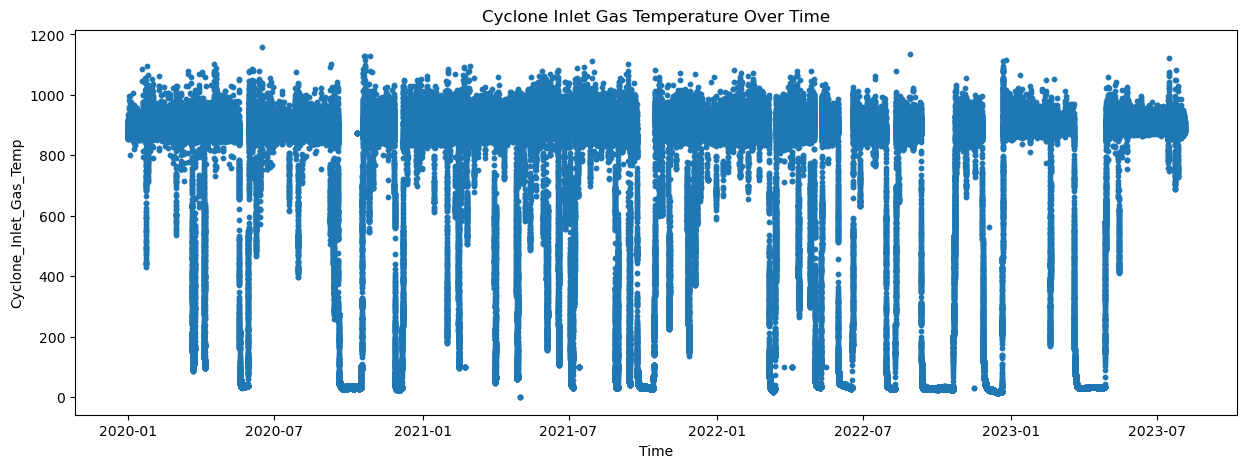

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert column to numeric, coerce errors to NaN
df['Cyclone_Inlet_Gas_Temp'] = pd.to_numeric(df['Cyclone_Inlet_Gas_Temp'], errors='coerce')

# Optionally drop NaN rows (from 'I/O Timeout' or other bad values)
df_clean = df.dropna(subset=['Cyclone_Inlet_Gas_Temp'])

# Plot
plt.figure(figsize=(15,5))
plt.scatter(df_clean.index, df_clean['Cyclone_Inlet_Gas_Temp'], s=10)  # simple scatter
plt.xlabel('Time')
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.title('Cyclone Inlet Gas Temperature Over Time')
plt.show()


In [ ]:
# Requires: pandas, numpy, scikit-learn, matplotlib, scipy
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from scipy import stats
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
CLUSTER_COL = 'cluster'        # column name for cluster id
TS_COL = None                  # None if index is datetime; else name of datetime column
FEATURES = None                # list of feature column names; if None -> use all numeric except cluster
ISOF_PARAMS = dict(n_estimators=200, max_samples='auto', contamination=0.01, random_state=42)
MIN_EVENT_GAP = pd.Timedelta('30s')  # gap to merge anomaly samples into same event (adjust to your sample rate)
# ----------------------------

def prepare_df(df):
    """Ensure datetime index and features list"""
    df = df.copy()
    if TS_COL is not None:
        df[TS_COL] = pd.to_datetime(df[TS_COL])
        df = df.set_index(TS_COL)
    if FEATURES is None:
        exclude = [CLUSTER_COL]
        features = df.select_dtypes(include=[np.number]).columns.difference(exclude).tolist()
    else:
        features = FEATURES
    return df.sort_index(), features

# 1) Fit per-cluster anomaly detectors
def fit_cluster_models(df, features, model_type='isof', models=None, scaler=None):
    """
    Fit cluster-specific models. Returns dict {cluster: model}, and a scaler per-cluster if desired.
    model_type: 'isof' or 'lof'
    """
    models = {}
    scalers = {}
    for c, g in df.groupby(CLUSTER_COL):
        X = g[features].values
        # fit scaler
        sc = StandardScaler()
        Xs = sc.fit_transform(X)
        scalers[c] = sc
        if model_type == 'isof':
            m = IsolationForest(**ISOF_PARAMS)
            m.fit(Xs)
        elif model_type == 'lof':
            # LOF cannot be used to 'predict' new samples straightforwardly; we use fitted LOF on same data
            m = LocalOutlierFactor(n_neighbors=20, contamination=0.01, novelty=False)
            m.fit(Xs)
        else:
            raise ValueError('Unknown model_type')
        models[c] = m
    return models, scalers

# 2) Score and flag anomalies
def score_and_flag(df, features, models, scalers, model_type='isof', threshold=None):
    """
    Adds columns:
      - anomaly_score (higher means more anomalous when using -score from IsolationForest)
      - is_anomaly (bool)
    For LOF we use negative_outlier_factor_.
    """
    df = df.copy()
    scores = np.full(len(df), np.nan)
    for c, g in df.groupby(CLUSTER_COL):
        idx = g.index
        X = g[features].values
        sc = scalers[c]
        Xs = sc.transform(X)
        m = models[c]
        if model_type == 'isof':
            # decision_function: larger is more normal -> invert so larger is more anomalous
            raw = -m.decision_function(Xs)  # higher = more anomalous
            # Normalize per-cluster to z-like
            if np.nanstd(raw) > 0:
                raw = (raw - np.nanmean(raw)) / np.nanstd(raw)
        else:  # LOF
            # negative_outlier_factor_ -> lower more anomalous; invert and normalize
            raw = -m._decision_function(Xs) if hasattr(m, '_decision_function') else -m.negative_outlier_factor_
            if np.nanstd(raw) > 0:
                raw = (raw - np.nanmean(raw)) / np.nanstd(raw)
        scores[df.index.isin(idx)] = raw
    df['anomaly_score'] = scores
    # default threshold: score > 2 (approx 2 sigma) flagged as anomaly; you can change
    if threshold is None:
        threshold = 2.0
    df['is_anomaly'] = df['anomaly_score'] > threshold
    return df

# 3) Collapse anomaly samples into events
def collapse_anomalies_to_events(df):
    """
    Returns a dataframe 'events' with columns: event_id, start, end, duration_s, cluster_before, cluster_during, ...
    """
    anom = df[df['is_anomaly']].copy()
    if anom.empty:
        return pd.DataFrame([], columns=[
            'event_id','start','end','duration_s','n_samples','clusters','peak_score','implicated_vars'])
    # find contiguous blocks separated by > MIN_EVENT_GAP
    anom = anom.reset_index()
    anom['time_diff'] = anom.iloc[:,0].diff().fillna(pd.Timedelta(seconds=0))
    event_ids = (anom['time_diff'] > MIN_EVENT_GAP).cumsum()
    anom['event_id'] = event_ids
    events = []
    for eid, g in anom.groupby('event_id'):
        start = g.iloc[0,0]
        end = g.iloc[-1,0]
        duration_s = (end - start).total_seconds()
        peak_score = g['anomaly_score'].max()
        clusters = sorted(g[CLUSTER_COL].unique().tolist())
        n_samples = len(g)
        events.append(dict(
            event_id = int(eid),
            start = start,
            end = end,
            duration_s = duration_s,
            n_samples = n_samples,
            clusters = clusters,
            peak_score = peak_score
        ))
    events_df = pd.DataFrame(events).sort_values('start').reset_index(drop=True)
    return events_df

# 4) Implicated variables per event (heuristic)
def implicated_variables_for_event(df, event_row, features, top_k=4):
    """
    Heuristic: compute per-feature max absolute z-score relative to cluster distribution
    Return top_k features sorted by that measure.
    """
    # filter samples in event
    mask = (df.index >= event_row['start']) & (df.index <= event_row['end'])
    g = df.loc[mask]
    if g.empty:
        return []
    # For z-scores: compare each feature to the cluster-specific baseline (mean/std at same cluster)
    imp_scores = {}
    for f in features:
        # per-sample zscore relative to cluster baseline(s) encountered in event
        zvals = []
        for c in g[CLUSTER_COL].unique():
            baseline = df[df[CLUSTER_COL]==c][f]
            if baseline.std() == 0 or np.isnan(baseline.std()):
                zvals.append(0.0)
            else:
                # compute z for samples in g that belong to cluster c
                samples = g[g[CLUSTER_COL]==c][f]
                if len(samples)==0:
                    continue
                z = np.abs((samples - baseline.mean()) / baseline.std())
                zvals.append(z.max())
        imp_scores[f] = np.nanmax(zvals) if len(zvals)>0 else 0.0
    # rank by score
    ranked = sorted(imp_scores.items(), key=lambda x: x[1], reverse=True)
    return [f for f,score in ranked[:top_k]]

# 5) Automated root-cause hypothesis (simple heuristic rules)
def propose_root_cause(df, event_row, features):
    """
    Returns one or more textual hypotheses for the event, with evidence pointers.
    Heuristics used:
      - sudden large delta in a variable at the event start -> 'sudden change' candidate
      - correlated variable spike before/after (cross-correlation or lag) -> upstream/downstream inference
      - which cluster the system was in immediately before event
    """
    mask = (df.index >= event_row['start'] - pd.Timedelta('10s')) & (df.index <= event_row['end'] + pd.Timedelta('10s'))
    g = df.loc[mask]
    hypotheses = []
    # cluster before/after
    before_t = event_row['start'] - pd.Timedelta('1s')
    if before_t in df.index:
        cluster_before = df.loc[before_t, CLUSTER_COL]
    else:
        # find last sample before start
        prev = df[df.index < event_row['start']]
        cluster_before = prev.iloc[-1][CLUSTER_COL] if len(prev)>0 else None
    clusters_in_event = event_row['clusters']

    # detect strong deltas at event start
    start = event_row['start']
    # sample at start and one step before (if available)
    try:
        s_idx = df.index.get_loc(start)
    except KeyError:
        # use nearest within tolerance
        s_idx = df.index.get_indexer([start], method='nearest')[0]
    if s_idx > 0:
        prev_idx = s_idx - 1
        sample = df.iloc[s_idx]
        prev = df.iloc[prev_idx]
        # compute percent changes and z-based deltas
        deltas = {}
        for f in features:
            denom = (prev[f] if prev[f] != 0 else 1e-9)
            pct = (sample[f] - prev[f]) / denom
            deltas[f] = np.abs(pct)
        big_changes = [f for f,v in deltas.items() if v > 0.05]  # >5% change heuristic; tune as needed
        if big_changes:
            hypotheses.append(f"Large immediate change in {', '.join(big_changes)} at event start — suggests a sudden shift (sensor spike, actuator movement, or process upset).")

    # check co-occurring strong anomalies in implicated vars
    imp = implicated_variables_for_event(df, event_row, features, top_k=6)
    if imp:
        hypotheses.append(f"Top implicated variables during event: {', '.join(imp)} — investigate sensors/actuators linked to these signals.")

    # cluster-context reasoning
    hypotheses.append(f"System was in cluster(s) {clusters_in_event} during the event; previous cluster was {cluster_before}. If cluster changed into a lower/higher-load state, that explains some shifts.")

    # Example domain-specific rule (user replace names): if 'Cyclone_Gas_Outlet_Temp' and 'Cyclone_Inlet_Draft' both implicated, propose upstream draft surge
    # This is a placeholder demo; replace variable names with your domain ones:
    if 'Cyclone_Gas_Outlet_Temp' in imp and 'Cyclone_Inlet_Draft' in imp:
        hypotheses.append("Observed sudden drop in Cyclone_Gas_Outlet_Temp coincident with spike in Cyclone_Inlet_Draft → likely upstream draft surge or partial inlet blockage clearing.")
    return hypotheses

# 6) Visualization helper
def plot_event_with_context(df, event_row, features, figsize=(14,6), annotate_implicated=True):
    """
    Plot a subset of features for the event with shading for the event duration and cluster labels shown on a separate axis.
    """
    start = event_row['start']
    end = event_row['end']
    margin = pd.Timedelta(seconds=max(30, int(event_row['duration_s'])))  # show some margin
    plot_mask = (df.index >= start - margin) & (df.index <= end + margin)
    sub = df.loc[plot_mask]
    nplots = min(6, len(features))
    sel_features = features[:nplots]
    fig, axes = plt.subplots(nplots+1, 1, figsize=(figsize[0], figsize[1] + 2*nplots), sharex=True)
    for i, f in enumerate(sel_features):
        axes[i].plot(sub.index, sub[f], linewidth=1)
        axes[i].set_ylabel(f)
        # shade event
        axes[i].axvspan(start, end, alpha=0.15, color='red')
    # cluster subplot
    axes[-1].plot(sub.index, sub[CLUSTER_COL], drawstyle='steps-post')
    axes[-1].set_ylabel('cluster')
    axes[-1].set_xlabel('time')
    plt.suptitle(f"Event {event_row['event_id']} | start: {start} | dur(s): {int(event_row['duration_s'])} | clusters: {event_row['clusters']}")
    plt.tight_layout()
    plt.show()

# ---------- Full run function ----------
def run_contextual_anomaly_pipeline(df_raw):
    df, features = prepare_df(df_raw)
    models, scalers = fit_cluster_models(df, features, model_type='isof')
    scored = score_and_flag(df, features, models, scalers, model_type='isof', threshold=2.0)
    events_df = collapse_anomalies_to_events(scored)
    # add implicated features + hypotheses
    implicated = []
    hypotheses = []
    for _, ev in events_df.iterrows():
        imp = implicated_variables_for_event(scored, ev, features, top_k=6)
        implicated.append(imp)
        hyp = propose_root_cause(scored, ev, features)
        hypotheses.append(hyp)
    events_df['implicated_vars'] = implicated
    events_df['hypotheses'] = hypotheses
    return scored, events_df, features
